In [1]:
!pip install pkbar tensorflow-model-optimization -q

     |████████████████████████████████| 234 kB 4.4 MB/s 


In [2]:
from tqdm import tqdm
from IPython import display
from tensorflow import keras
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-darkgrid')

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_model_optimization as tfmot

from tensorflow.keras import datasets, layers, models
from theano import tensor as tt
from pymc3 import Bound, Beta, Deterministic, Gamma, Normal, NormalMixture

import seaborn as sns
import xarray as xr
import pandas as pd
import pymc3 as pm
import numpy as np
import scipy as sp
import arviz as az

import requests
import pkbar
import time
import glob
import os
import PIL
import imageio
import sklearn

In [3]:
def plot_image_and_label(predictions_array, true_label, img, class_names):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  img = np.reshape(img, (28, 28)) # drop any trailing dimension of size 1
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel("truth={}, pred={}, score={:2.0f}%".format(
      class_names[true_label],
      class_names[predicted_label],
      100*np.max(predictions_array)),
      color=color)
  
def plot_label_dist(predictions_array, true_label):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
 

def find_interesting_test_images(predictions, test_labels):
  # We select the first 9 images plus 6 error images
  pred = np.argmax(predictions, axis=1)
  errors = np.where(pred != test_labels)[0]
  print(errors.shape)
  ndx1 = range(9)
  ndx2 = errors[:6]
  ndx = np.concatenate((ndx1, ndx2))
  return ndx

def plot_interesting_test_results(test_images, test_labels, predictions,
                                  class_names, ndx):
  # Plot some test images, their predicted label, and the true label
  # Color correct predictions in blue, incorrect predictions in red
  num_rows = 5
  num_cols = 3
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
    n = ndx[i]
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image_and_label(predictions[n], test_labels[n], test_images[n],
                         class_names)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_label_dist(predictions[n], test_labels[n])
  plt.show()

Load the MNIST data

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.

11501568/11490434 [==============================] - 0s 0us/step


Create the model

In [5]:
model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  layers.MaxPooling2D((3, 3)),
  layers.Conv2D(32, (2, 2), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 32)          9248      
                                                                 
 flatten (Flatten)           (None, 32)                0

In [6]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [7]:
model.fit(
    x_train, 
    y_train,
    epochs=2,
    validation_data=(x_test, y_test)
)

Epoch 1/2
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2557 - accuracy: 0.9213 - sparse_categorical_accuracy: 0.9213 - val_loss: 0.0866 - val_accuracy: 0.9737 - val_sparse_categorical_accuracy: 0.9737
Epoch 2/2
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0866 - accuracy: 0.9729 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.0613 - val_accuracy: 0.9804 - val_sparse_categorical_accuracy: 0.9804


##TensorFlow's built-in way of performing weight clustering
We will extend on these methods and classes to plug our approach into the existing TensorFlow methodology

In [213]:
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 8,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(model, **clustering_params)

##Modified top-level clustering function (from TensorFlow module)
[Source](https://github.com/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/python/core/clustering/keras/cluster.py)

In [8]:
Layer = tf.keras.layers.Layer
InputLayer = tf.keras.layers.InputLayer

@classmethod
def make_clusterable(cls, layer):
  """Modifies a built-in layer object to support clustering.
  Args:
    layer: layer to modify for support.
  Returns:
    The modified layer object.
  """

  if not cls.supports(layer):
    raise ValueError('Layer ' + str(layer.__class__) + ' is not supported.')

  def get_clusterable_weights():
    return [(weight_name, getattr(layer, weight_name))
            for weight_name in cls._weight_names(layer)]


def _cluster_weights(to_cluster,
                     number_of_clusters,
                     cluster_centroids_init,
                     preserve_sparsity=False,
                     cluster_per_channel=False,
                     **kwargs):
  if not clustering_centroids.CentroidsInitializerFactory.init_is_supported(
      cluster_centroids_init):
    raise ValueError('Cluster centroid initialization {} not supported'.format(
        cluster_centroids_init))
  def _add_clustering_wrapper(layer):
    if isinstance(layer, tf.keras.Model):
      # Check whether the model is a subclass.
      # NB: This check is copied from keras.py file in tensorflow.
      # There is no available public API to do this check.
      # pylint: disable=protected-access
      if (not layer._is_graph_network and
          not isinstance(layer, tf.keras.models.Sequential)):
        raise ValueError('Subclassed models are not supported currently.')

      return tf.keras.models.clone_model(
          layer, input_tensors=None, clone_function=_add_clustering_wrapper)
    if isinstance(layer, cluster_wrapper.ClusterWeights):
      return layer
    if isinstance(layer, InputLayer):
      return layer.__class__.from_config(layer.get_config())
    if isinstance(layer, tf.keras.layers.RNN) or isinstance(
        layer, tf.keras.layers.Bidirectional):
      return cluster_wrapper.ClusterWeightsRNN(
          layer,
          number_of_clusters,
          cluster_centroids_init,
          preserve_sparsity,
          **kwargs,
      )
    if isinstance(layer, tf.keras.layers.MultiHeadAttention):
      return cluster_wrapper.ClusterWeightsMHA(
          layer,
          number_of_clusters,
          cluster_centroids_init,
          preserve_sparsity,
          **kwargs,
      )

    return ClusterWeights(layer, 2)

  def _wrap_list(layers):
    output = []
    for layer in layers:
      output.append(_add_clustering_wrapper(layer))

    return output

  if isinstance(to_cluster, tf.keras.Model):
    return tf.keras.models.clone_model(
        to_cluster, input_tensors=None, clone_function=_add_clustering_wrapper)
  if isinstance(to_cluster, Layer):
    return _add_clustering_wrapper(layer=to_cluster)
  if isinstance(to_cluster, list):
    return _wrap_list(to_cluster)

##Modified layer holding the cluster weights and mappings
[Source](https://github.com/tensorflow/model-optimization/blob/4924fd30d6dd40422f5d5c045b7a08940bdf8a8f/tensorflow_model_optimization/python/core/clustering/keras/cluster_wrapper.py#L35)

In [9]:
from tensorflow_model_optimization.python.core.clustering.keras import cluster_config
from tensorflow_model_optimization.python.core.clustering.keras import cluster_wrapper
from tensorflow_model_optimization.python.core.clustering.keras import clusterable_layer
from tensorflow_model_optimization.python.core.clustering.keras import clustering_centroids
from tensorflow_model_optimization.python.core.clustering.keras import clustering_registry

CentroidInitialization = cluster_config.CentroidInitialization
GradientAggregation = cluster_config.GradientAggregation

class ClusterWeights(keras.layers.Wrapper):
  """This wrapper augments a layer so the weight tensor(s) can be clustered.
  This wrapper implements nearest neighbor clustering algorithm. This algorithm
  ensures that only a specified number of unique values are used in a weight
  tensor. This allows for certain types of hardware to benefit from advanced
  weight compression techniques and the associated reduction in model memory
  footprint and bandwidth.
  From practical standpoint this is implemented using a lookup table to hold the
  cluster centroid values during model training. The weight array is populated
  with 'gather' operation so that during back propagation the gradients can be
  calculated in a normal way. The lookup table is then adjusted using the
  cumulative gradient values for the weights that correspond to the same
  centroid.
  The number of unique values required as well as the way cluster centroids
  are initialized are passed in the wrapper's constructor.
  The initial values of cluster centroids are fine-tuned during the training.
  """

  def __init__(self,
               layer,
               number_of_clusters = 2,
               cluster_centroids_init=CentroidInitialization.KMEANS_PLUS_PLUS,
               preserve_sparsity=False,
               cluster_per_channel=False,
               cluster_gradient_aggregation=GradientAggregation.SUM,
               **kwargs):
    if not isinstance(layer, Layer):
      raise ValueError(
          'Please initialize `Cluster` layer with a '
          '`Layer` instance. You passed: {input}'.format(input=layer))

    if 'name' not in kwargs:
      kwargs['name'] = self._make_layer_name(layer)

    if isinstance(layer, clusterable_layer.ClusterableLayer):
      # A user-defined custom layer
      super(ClusterWeights, self).__init__(layer, **kwargs)
    elif clustering_registry.ClusteringRegistry.supports(layer):
      super(ClusterWeights, self).__init__(
          clustering_registry.ClusteringRegistry.make_clusterable(layer),
          **kwargs)
    else:
      raise ValueError(
          'Please initialize `Cluster` with a supported layer. Layers should '
          'either be a `ClusterableLayer` instance, or should be supported by '
          'the ClusteringRegistry. You passed: {input}'.format(
              input=layer.__class__))

    if not isinstance(number_of_clusters, int):
      raise ValueError(
          'number_of_clusters must be an integer. Given: {}'.format(
              number_of_clusters.__class__))

    limit_number_of_clusters = 2 if preserve_sparsity else 1
    if number_of_clusters <= limit_number_of_clusters:
      raise ValueError(
          'number_of_clusters must be greater than {}. Given: {}'.format(
              limit_number_of_clusters, number_of_clusters))

    self._track_trackable(layer, name='layer')

    # The way how cluster centroids will be initialized
    self.cluster_centroids_init = cluster_centroids_init

    # The number of cluster centroids
    self.number_of_clusters = number_of_clusters

    # Whether to cluster Conv2D kernels per-channel.
    # In case the layer isn't a Conv2D, this isn't applicable
    self.cluster_per_channel = (
        cluster_per_channel if isinstance(layer, tf.keras.layers.Conv2D)
        else False)

    # Number of channels in a Conv2D layer, to be used the case of per-channel
    # clustering.
    self.num_channels = None

    # Whether to apply sparsity preservation or not
    self.preserve_sparsity = preserve_sparsity

    # The way to aggregate the gradient of each cluster centroid
    self.cluster_gradient_aggregation = cluster_gradient_aggregation

    # Stores the pairs of weight names and their respective sparsity masks
    self.sparsity_masks = {}

    # Stores the pairs of weight names and the zero centroids
    self.zero_idx = {}

    # Map weight names to original clusterable weights variables
    # Those weights will still be updated during backpropagation
    self.original_clusterable_weights = {}

    # Map the position of the original weight variable in the
    # child layer to the weight name
    self.position_original_weights = {}

    # Map weight names to corresponding clustering algorithms
    self.clustering_algorithms = {}

    # Map weight names to corresponding indices lookup tables
    self.pulling_indices = {}

    # Map weight names to corresponding cluster centroid variables
    self.cluster_centroids = {}

    # If the input shape was specified, then we need to preserve this
    # information in the layer. If this info is not preserved, then the `built`
    # state will not be preserved between serializations.
    if (not hasattr(self, '_batch_input_shape') and
        hasattr(layer, '_batch_input_shape')):
      self._batch_input_shape = self.layer._batch_input_shape

    # In the case of Conv2D layer, the data_format needs to be preserved to be
    # used for per-channel clustering
    if hasattr(layer, 'data_format'):
      self.data_format = self.layer.data_format
    else:
      self.data_format = None

    # Save the input shape specified in the build
    self.build_input_shape = None

  def _make_layer_name(self, layer):
    return '{}_{}'.format('cluster', layer.name)

  def _get_zero_idx_mask(self, centroids, zero_cluster):
    zero_idx_mask = (tf.cast(tf.math.not_equal(centroids,
                                               zero_cluster),
                             dtype=tf.float32))
    return zero_idx_mask

  def _get_zero_centroid(self, centroids, zero_idx_mask):
    zero_centroid = tf.math.multiply(centroids,
                                     zero_idx_mask)
    return zero_centroid

  def get_weight_from_layer(self, weight_name):
    return getattr(self.layer, weight_name)

  def set_weight_to_layer(self, weight_name, new_weight):
    setattr(self.layer, weight_name, new_weight)

  def build(self, input_shape):
    super(ClusterWeights, self).build(input_shape)
    self.build_input_shape = input_shape

    # For every clusterable weights, create the clustering logic
    for weight_name, weight in self.layer.get_clusterable_weights():
      # Store the original weight in this wrapper
      # The child reference will be overridden in
      # update_clustered_weights_associations
      # The actual weight_name here for the clustering wrapper is not
      # necessarily the same as the original one from the layer wrapped.
      # For example for cells in StackedRNNCell, the names become
      # 'kernel/0', 'recurrent_kernel/0', 'kernel/1', 'recurrent_kernel/1'
      original_weight = self.get_weight_from_layer(weight_name)
      self.original_clusterable_weights[weight_name] = original_weight
      # Track the variable
      setattr(self, 'original_weight_' + weight_name,
              original_weight)
      # Store the position in layer.weights of original_weight to restore during
      # stripping
      position_original_weight = next(
          i for i, w in enumerate(self.layer.weights) if w is original_weight)
      self.position_original_weights[position_original_weight] = weight_name

      # In the case of per-channel clustering, the number of channels,
      # per-channel number of clusters, as well as the overall number
      # of clusters all need to be preserved in the wrapper.
      if self.cluster_per_channel:
        self.num_channels = (
            original_weight.shape[1] if self.data_format == 'channels_first'
            else original_weight.shape[-1])
        

      dpm = DPGMM(weight)
      cluster_centroids, pulling_indices = dpm.centroids, dpm.clustering
      #centroid_init_factory = clustering_centroids.CentroidsInitializerFactory
      #centroid_init = centroid_init_factory.get_centroid_initializer(
      #    self.cluster_centroids_init)(weight, self.number_of_clusters,
      #                                 self.cluster_per_channel,
      #                                 self.num_channels,
      #                                 self.preserve_sparsity)

      # Init the cluster centroids
      #cluster_centroids = (centroid_init.get_cluster_centroids())

      
      self.cluster_centroids[weight_name] = self.add_weight(
          '{}{}'.format('cluster_centroids_', weight_name),
          shape=(cluster_centroids.shape),
          dtype=weight.dtype,
          trainable=True,
          initializer=tf.keras.initializers.Constant(value=cluster_centroids))
      
      #self.clustering_algorithms[weight_name] = (
      #    clustering_registry.ClusteringLookupRegistry().get_clustering_impl(
      #        self.layer, weight_name, self.cluster_per_channel)
      #    (
      #        clusters_centroids=self.cluster_centroids[weight_name],
      #        cluster_gradient_aggregation=self.cluster_gradient_aggregation,
      #        data_format=self.data_format,
      #    ))

      #pulling_indices = (
      #    self.clustering_algorithms[weight_name].get_pulling_indices(
      #        weight))
      self.pulling_indices[weight_name] = self.add_weight(
          '{}{}'.format('pulling_indices_', weight_name),
          shape=pulling_indices.shape,
          dtype=tf.int64,
          trainable=False,
          synchronization=tf.VariableSynchronization.ON_READ,
          aggregation=tf.VariableAggregation.ONLY_FIRST_REPLICA,
          initializer=tf.keras.initializers.Constant(value=pulling_indices))
      

#The Bayesian Dirich Process Mixture for Weight Sharing
Extends on clustering_centroid classes from [TensorFlow library](https://github.com/tensorflow/model-optimization/blob/4924fd30d6dd40422f5d5c045b7a08940bdf8a8f/tensorflow_model_optimization/python/core/clustering/keras/clustering_centroids.py)

In [10]:
!mkdir visualization

In [15]:
CentroidInitialization = cluster_config.CentroidInitialization

class DPGMM(clustering_centroids.AbstractCentroidsInitialisation):
  def __init__(
      self, 
      weights, 
      K_threshold = 8, 
      samples=2000, 
      tuning_steps = 2500,
      no_chains=2,
      mu_alpha_lower = 0.,
      mu_alpha_upper = 1.,
      sigma_alpha_lower = 0.,
      sigma_alpha_upper = 1.,
      tau_alpha = .5,
      tau_beta = .5,
      lambda_alpha = 10.,
      lambda_beta = 1.,
      SEED = 42069
    ):
    self.weights = weights
    self.weight_shape = weights.shape
    self.K_thres = K_threshold
    self.samples = samples
    self.tuning_steps = tuning_steps
    self.no_chains = no_chains
    self.SEED = SEED
    self.shape_list = [self.no_chains * self.samples, self.K_thres]
    self.mu_alpha_lower = mu_alpha_lower
    self.mu_alpha_upper = mu_alpha_upper
    self.sigma_alpha_lower = sigma_alpha_lower
    self.sigma_alpha_upper = sigma_alpha_upper
    self.tau_alpha = tau_alpha
    self.tau_beta = tau_beta
    self.lambda_alpha = lambda_alpha
    self.lambda_beta = lambda_beta
    print(self.weight_shape)
    self.centroids, self.clustering = self.sample()

  def stick_breaking(self, beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

  def sample(self):
    unrolled_weights = tf.reshape(self.weights, shape=[-1])
    nice_name = self.weights.name.replace("/", "-").replace(":", "-") # formatting for saving plots

    with pm.Model() as dpm_model:
        alpha = Beta("alpha", 4., 20.)
        
        beta = Beta("beta", 1., alpha, shape=self.K_thres) # has to one due to stick-breaking process, confusing because the alpha variable is the beta param
        
        w = Deterministic("w", self.stick_breaking(beta))

        tau = Beta("tau", 5., 1.25, shape=self.K_thres)
        lambda_ = Gamma("lambda_", 4., .005, shape=self.K_thres)
        mu = Bound(Normal, lower=-1., upper=1.)("mu", 0.0, tau=tau * lambda_, shape=self.K_thres)
        
        data = pm.Data("data", unrolled_weights)
        obs = NormalMixture("obs", w, mu, tau = tau * lambda_, observed=data)

        inference = pm.sample(
          self.samples, 
          tune = self.tuning_steps, 
          chains = self.no_chains, 
          init = "advi",
          target_accept=0.8,
          random_seed=self.SEED, 
          return_inferencedata=True,
          #start={"mu": np.array([0.]*self.K_thres)}
        )
        trace = inference.posterior
        trace_w = np.reshape(trace["w"].values, self.shape_list)
        trace_mu = np.reshape(trace["mu"].values, self.shape_list)
        trace_lambda = np.reshape(trace["lambda_"].values, self.shape_list)
        trace_tau = np.reshape(trace["tau"].values, self.shape_list)

        # Traceplot
        pm.plot_trace(trace)
        fig = plt.gcf()
        fig.savefig(f"visualization/traceplot_{nice_name}.png")

        # Weight mixing
        fig, ax = plt.subplots(figsize=(8, 6))
        plot_w = np.arange(self.K_thres) + 1

        ax.bar(plot_w, trace_w.mean(axis=0), width=1.0)
        ax.set_xlim(0.5, self.K_thres)
        ax.set_xlabel("Component")
        ax.set_xticks(plot_w)
        ax.set_ylabel("Posterior expected mixture weight")
        fig.savefig(f"visualization/mixing_weighting_{nice_name}.png")

        # Density estimation fit
        x_plot = np.linspace(np.min(self.weights), np.max(self.weights))
        post_pdf_contribs = sp.stats.norm.pdf(
            np.atleast_3d(x_plot),
            trace_mu[:, np.newaxis, :],
            1.0 / np.sqrt(trace_lambda * trace_tau)[:, np.newaxis, :]
        )
        post_pdfs = (trace_w[:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)
        post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

        fig, ax = plt.subplots(figsize=(8, 6))

        ax.hist(unrolled_weights, bins=20, density=True, alpha=0.5)
        ax.fill_between(x_plot, post_pdf_low, post_pdf_high, color="gray", alpha=0.45)
        ax.plot(x_plot, post_pdfs[0], c="gray", label="Posterior sample densities")
        ax.plot(x_plot, post_pdfs[::self.samples//20].T, c="gray")
        ax.plot(x_plot, post_pdfs.mean(axis=0), c="k", label="Posterior expected density")

        ax.set_xlabel(f"Weights of layer {self.weights.name}")
        ax.set_yticklabels([])
        ax.set_ylabel("Density")
        ax.legend(loc=2)
        fig.savefig(f"visualization/density_estimation_fit_{nice_name}")

        # summary of traces
        summaries = pm.summary(trace, var_names=["w", "mu", "tau"]) #lambda_, tau

        # Autocorrelation plot
        az.plot_autocorr(inference, var_names=["w", "mu"])
        fig = plt.gcf()
        fig.savefig(f"visualization/autocorrelation_{nice_name}")

        # posterior plot
        az.plot_posterior(trace, var_names=["w", "mu"])
        fig = plt.gcf()
        fig.savefig(f"visualization/posterior_{nice_name}")
    

    clustering_weights = [
      trace_w.mean(0)[i] * 
      sp.stats.multivariate_normal(
          trace_mu.mean(0)[i], 
          1.0 / np.sqrt(trace_lambda.mean(0) * trace_tau.mean(0))[i]
      ).pdf(unrolled_weights) for i in range(self.K_thres)]
    #trace_tau.mean(0) * trace_lambda.mean(0))[i]
    clustering_unrolled = np.vstack(clustering_weights).argmax(axis=0)
    clustering = np.reshape(clustering_unrolled, newshape=self.weight_shape)
    
    centroids = trace_mu.mean(axis=0)

    return centroids, clustering    


  @classmethod
  def init_is_supported(cls, init_method):
    return init_method in cls._initialisers

  @classmethod
  def get_centroid_initializer(cls, init_method):
    if not cls.init_is_supported(init_method):
      raise ValueError(
          'Unknown initialisation method: {init_method}. Allowed values are : '
          '{allowed}'.format(
              init_method=init_method,
              allowed=','.join(cls._initialisers.keys())))

    return cls._initialisers[init_method]

(3, 3, 1, 32)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 33200
Interrupted at 33,199 [16%]: Average Loss = 116.67
Sequential sampling (2 chains in 1 job)
NUTS: [mu, lambda_, tau, beta]


Sampling 2 chains for 2_500 tune and 2_000 draw iterations (5_000 + 4_000 draws total) took 73 seconds.
There were 371 divergences after tuning. Increase `target_accept` or reparameterize.
There were 750 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


(2, 2, 32, 32)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 42600
Interrupted at 42,599 [21%]: Average Loss = -1,016.6
Sequential sampling (2 chains in 1 job)
NUTS: [mu, lambda_, tau, beta]


Sampling 2 chains for 2_500 tune and 2_000 draw iterations (5_000 + 4_000 draws total) took 2661 seconds.
There were 417 divergences after tuning. Increase `target_accept` or reparameterize.
There were 817 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


(3, 3, 32, 32)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 26900
Interrupted at 26,899 [13%]: Average Loss = -4,169.4
Sequential sampling (2 chains in 1 job)
NUTS: [mu, lambda_, tau, beta]


Sampling 2 chains for 2_500 tune and 2_000 draw iterations (5_000 + 4_000 draws total) took 7120 seconds.
There were 478 divergences after tuning. Increase `target_accept` or reparameterize.
There were 961 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


(32, 64)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 41300
Interrupted at 41,299 [20%]: Average Loss = -120.14
Sequential sampling (2 chains in 1 job)
NUTS: [mu, lambda_, tau, beta]


Sampling 2 chains for 2_500 tune and 2_000 draw iterations (5_000 + 4_000 draws total) took 432 seconds.
There were 435 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7021694136091633, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1356 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.41561074434450956, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


(64, 10)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 46600
Interrupted at 46,599 [23%]: Average Loss = 112.37
Sequential sampling (2 chains in 1 job)
NUTS: [mu, lambda_, tau, beta]


Sampling 2 chains for 2_500 tune and 2_000 draw iterations (5_000 + 4_000 draws total) took 159 seconds.
There were 365 divergences after tuning. Increase `target_accept` or reparameterize.
There were 934 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/traceplot.py:221: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**backend_kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot int

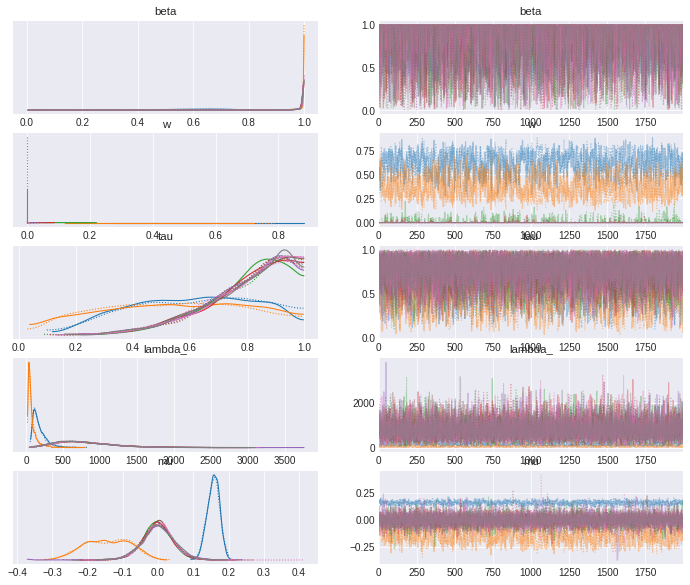

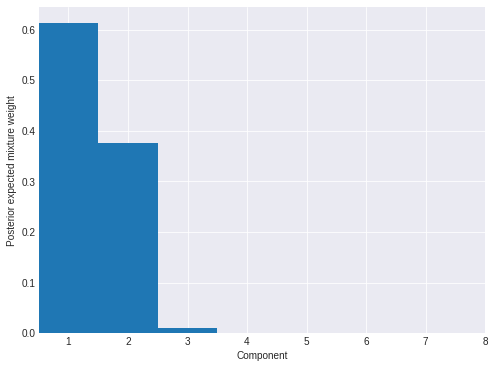

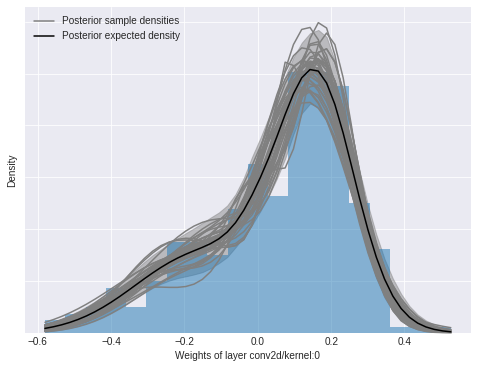

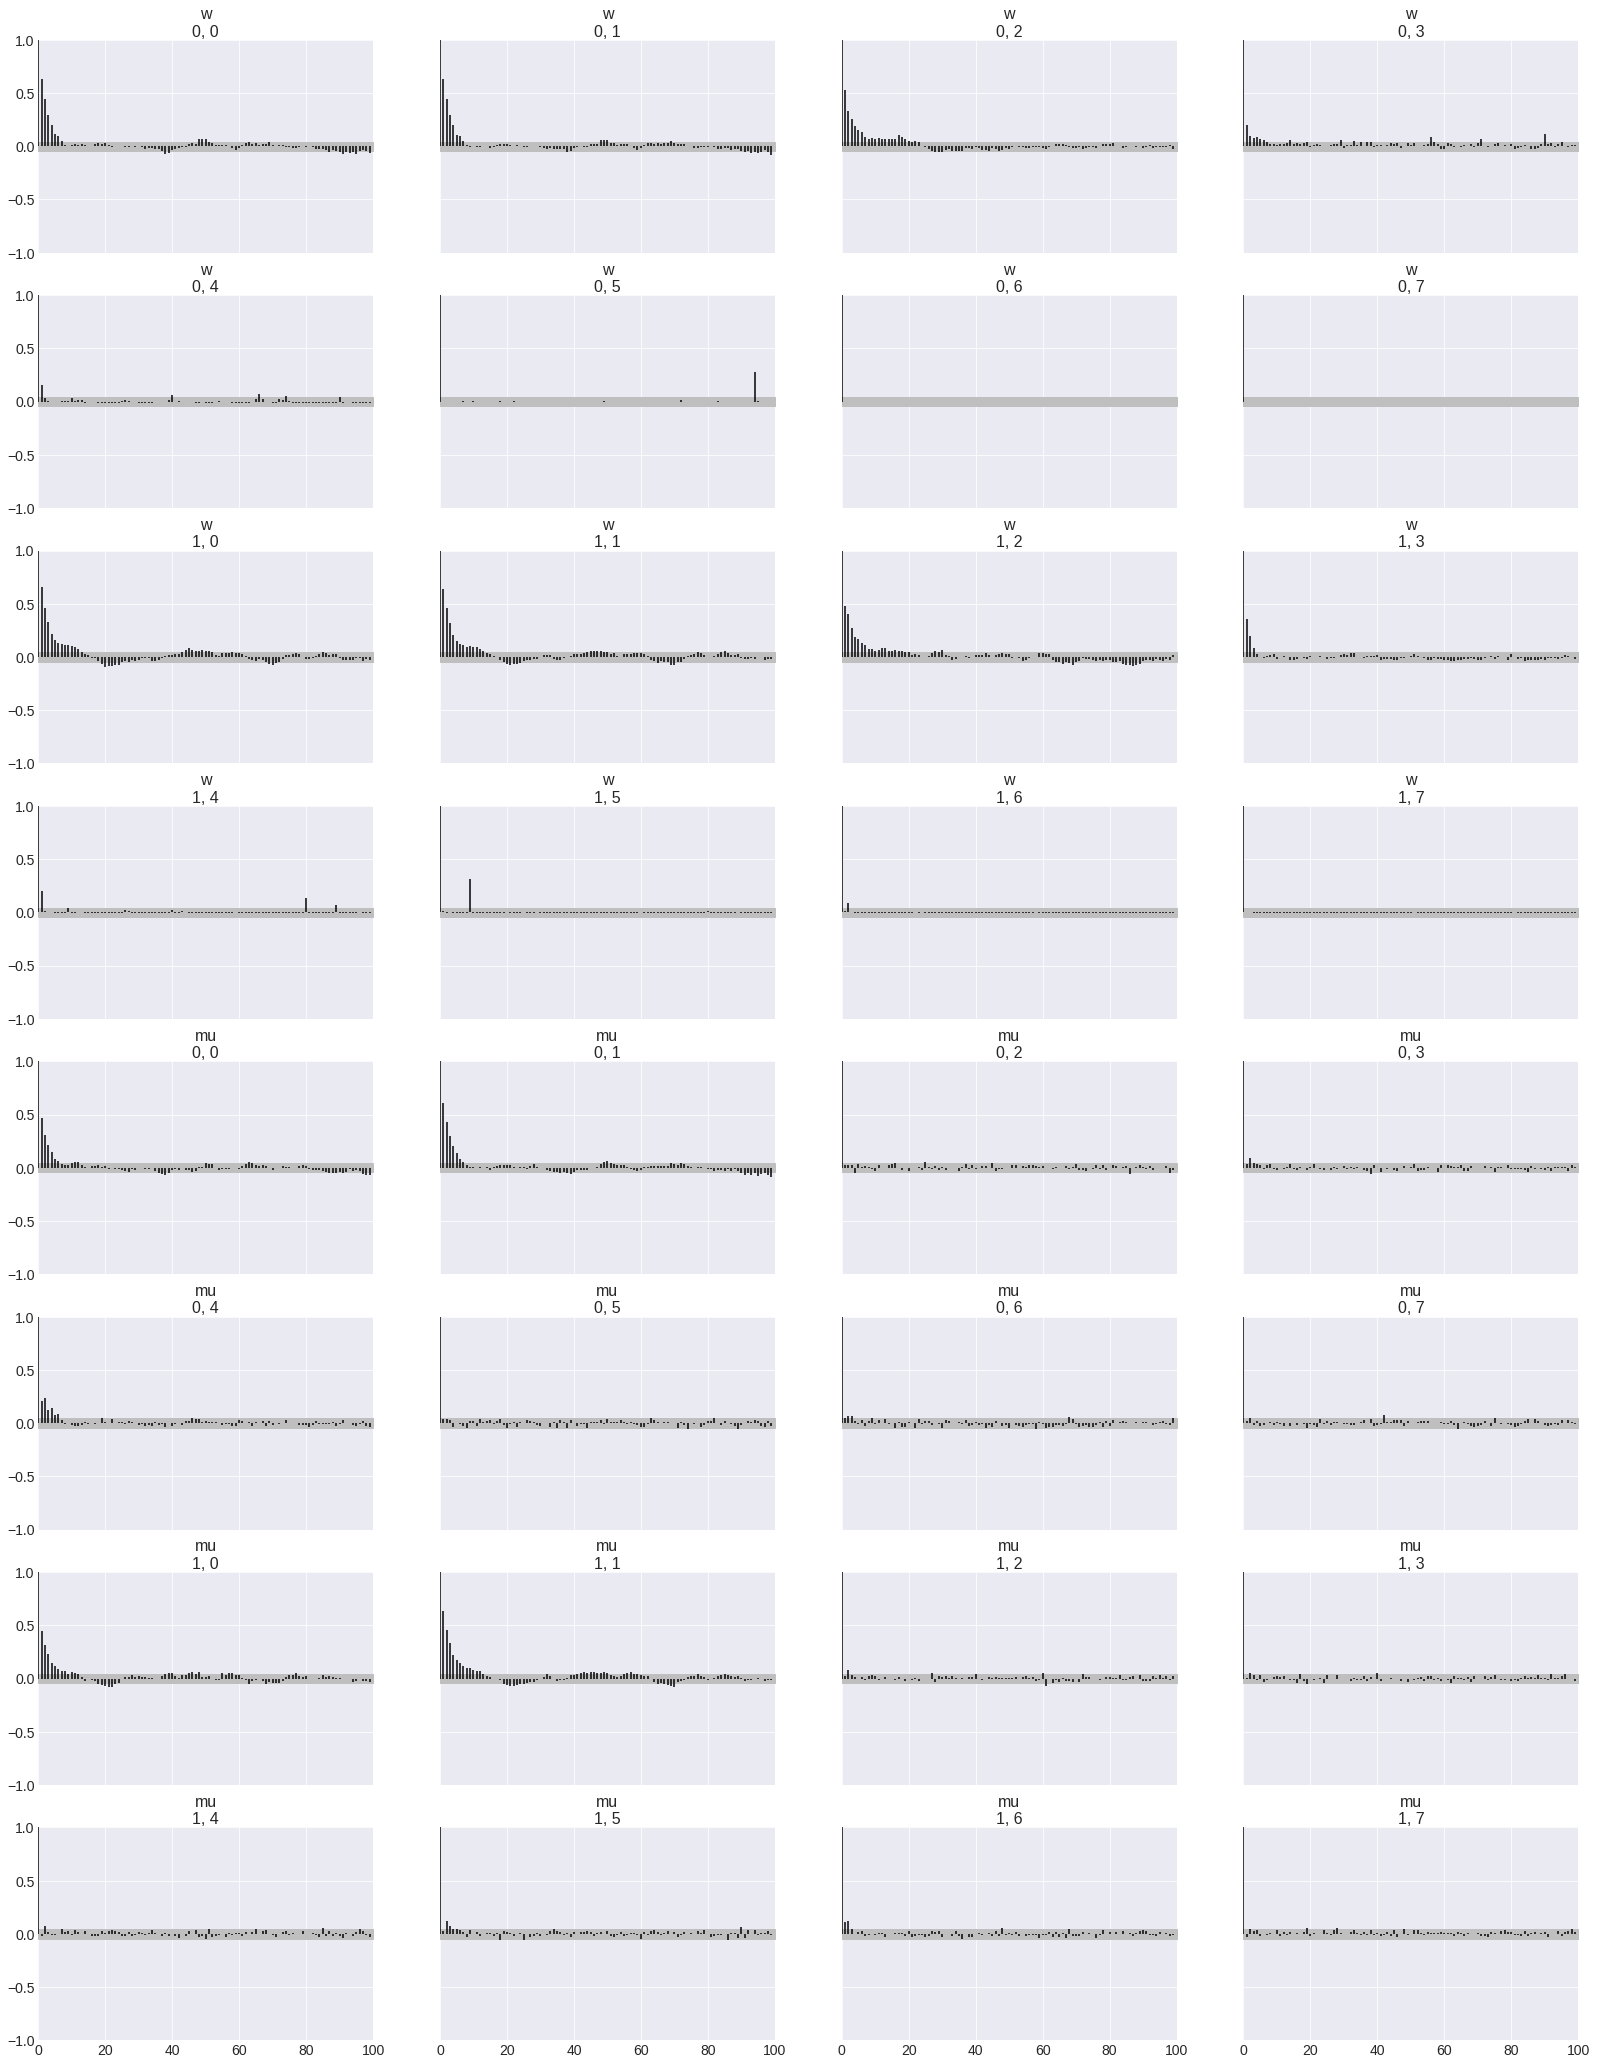

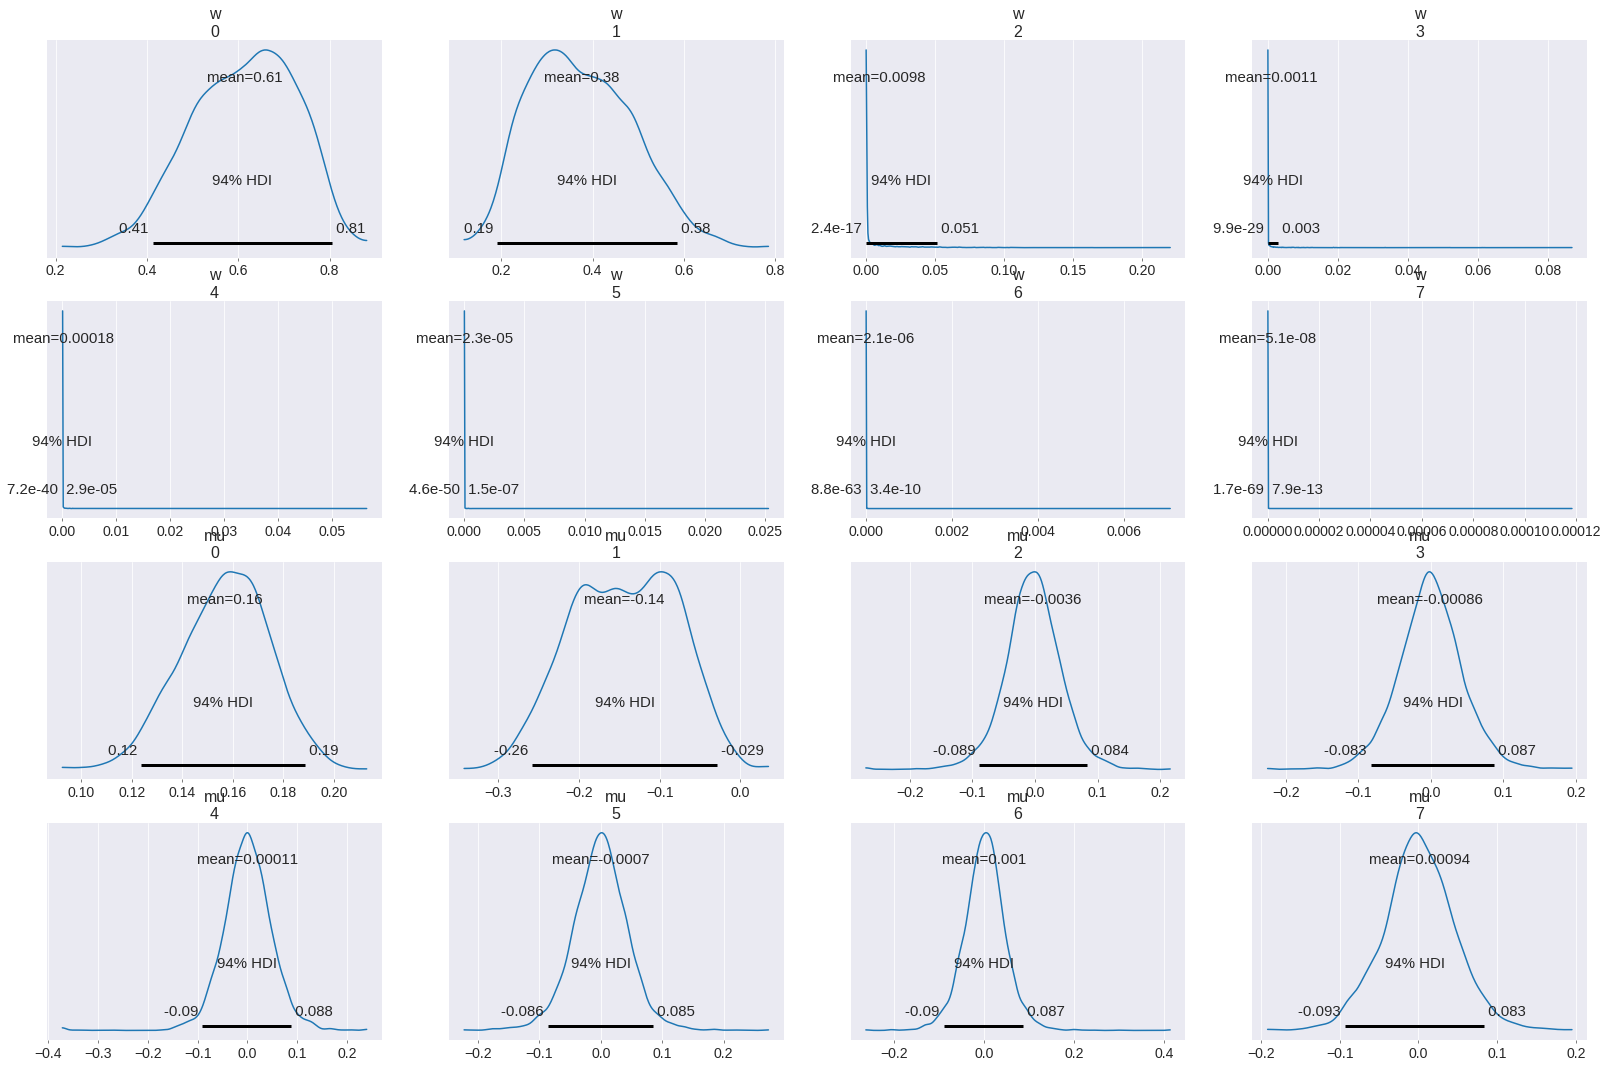

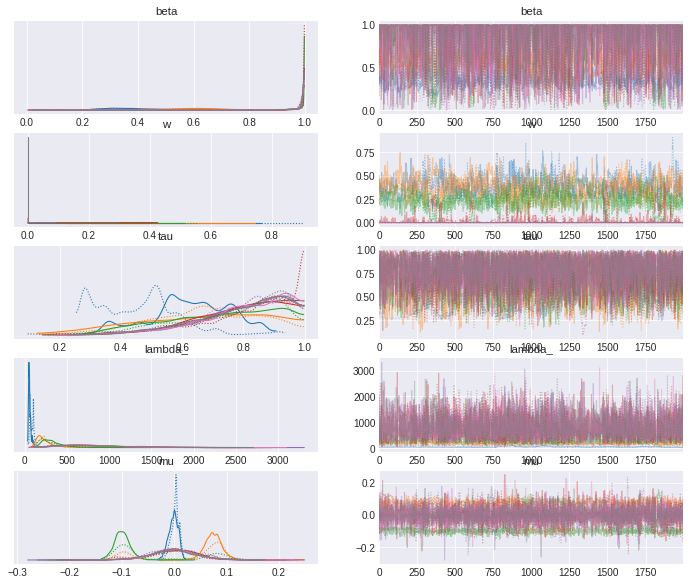

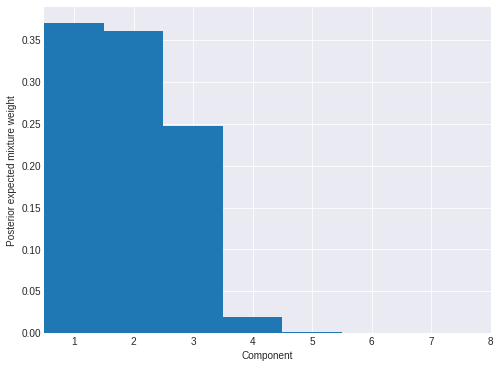

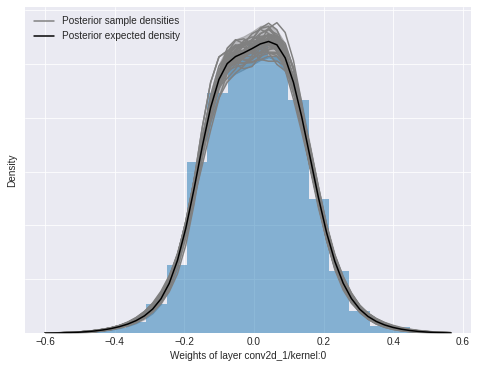

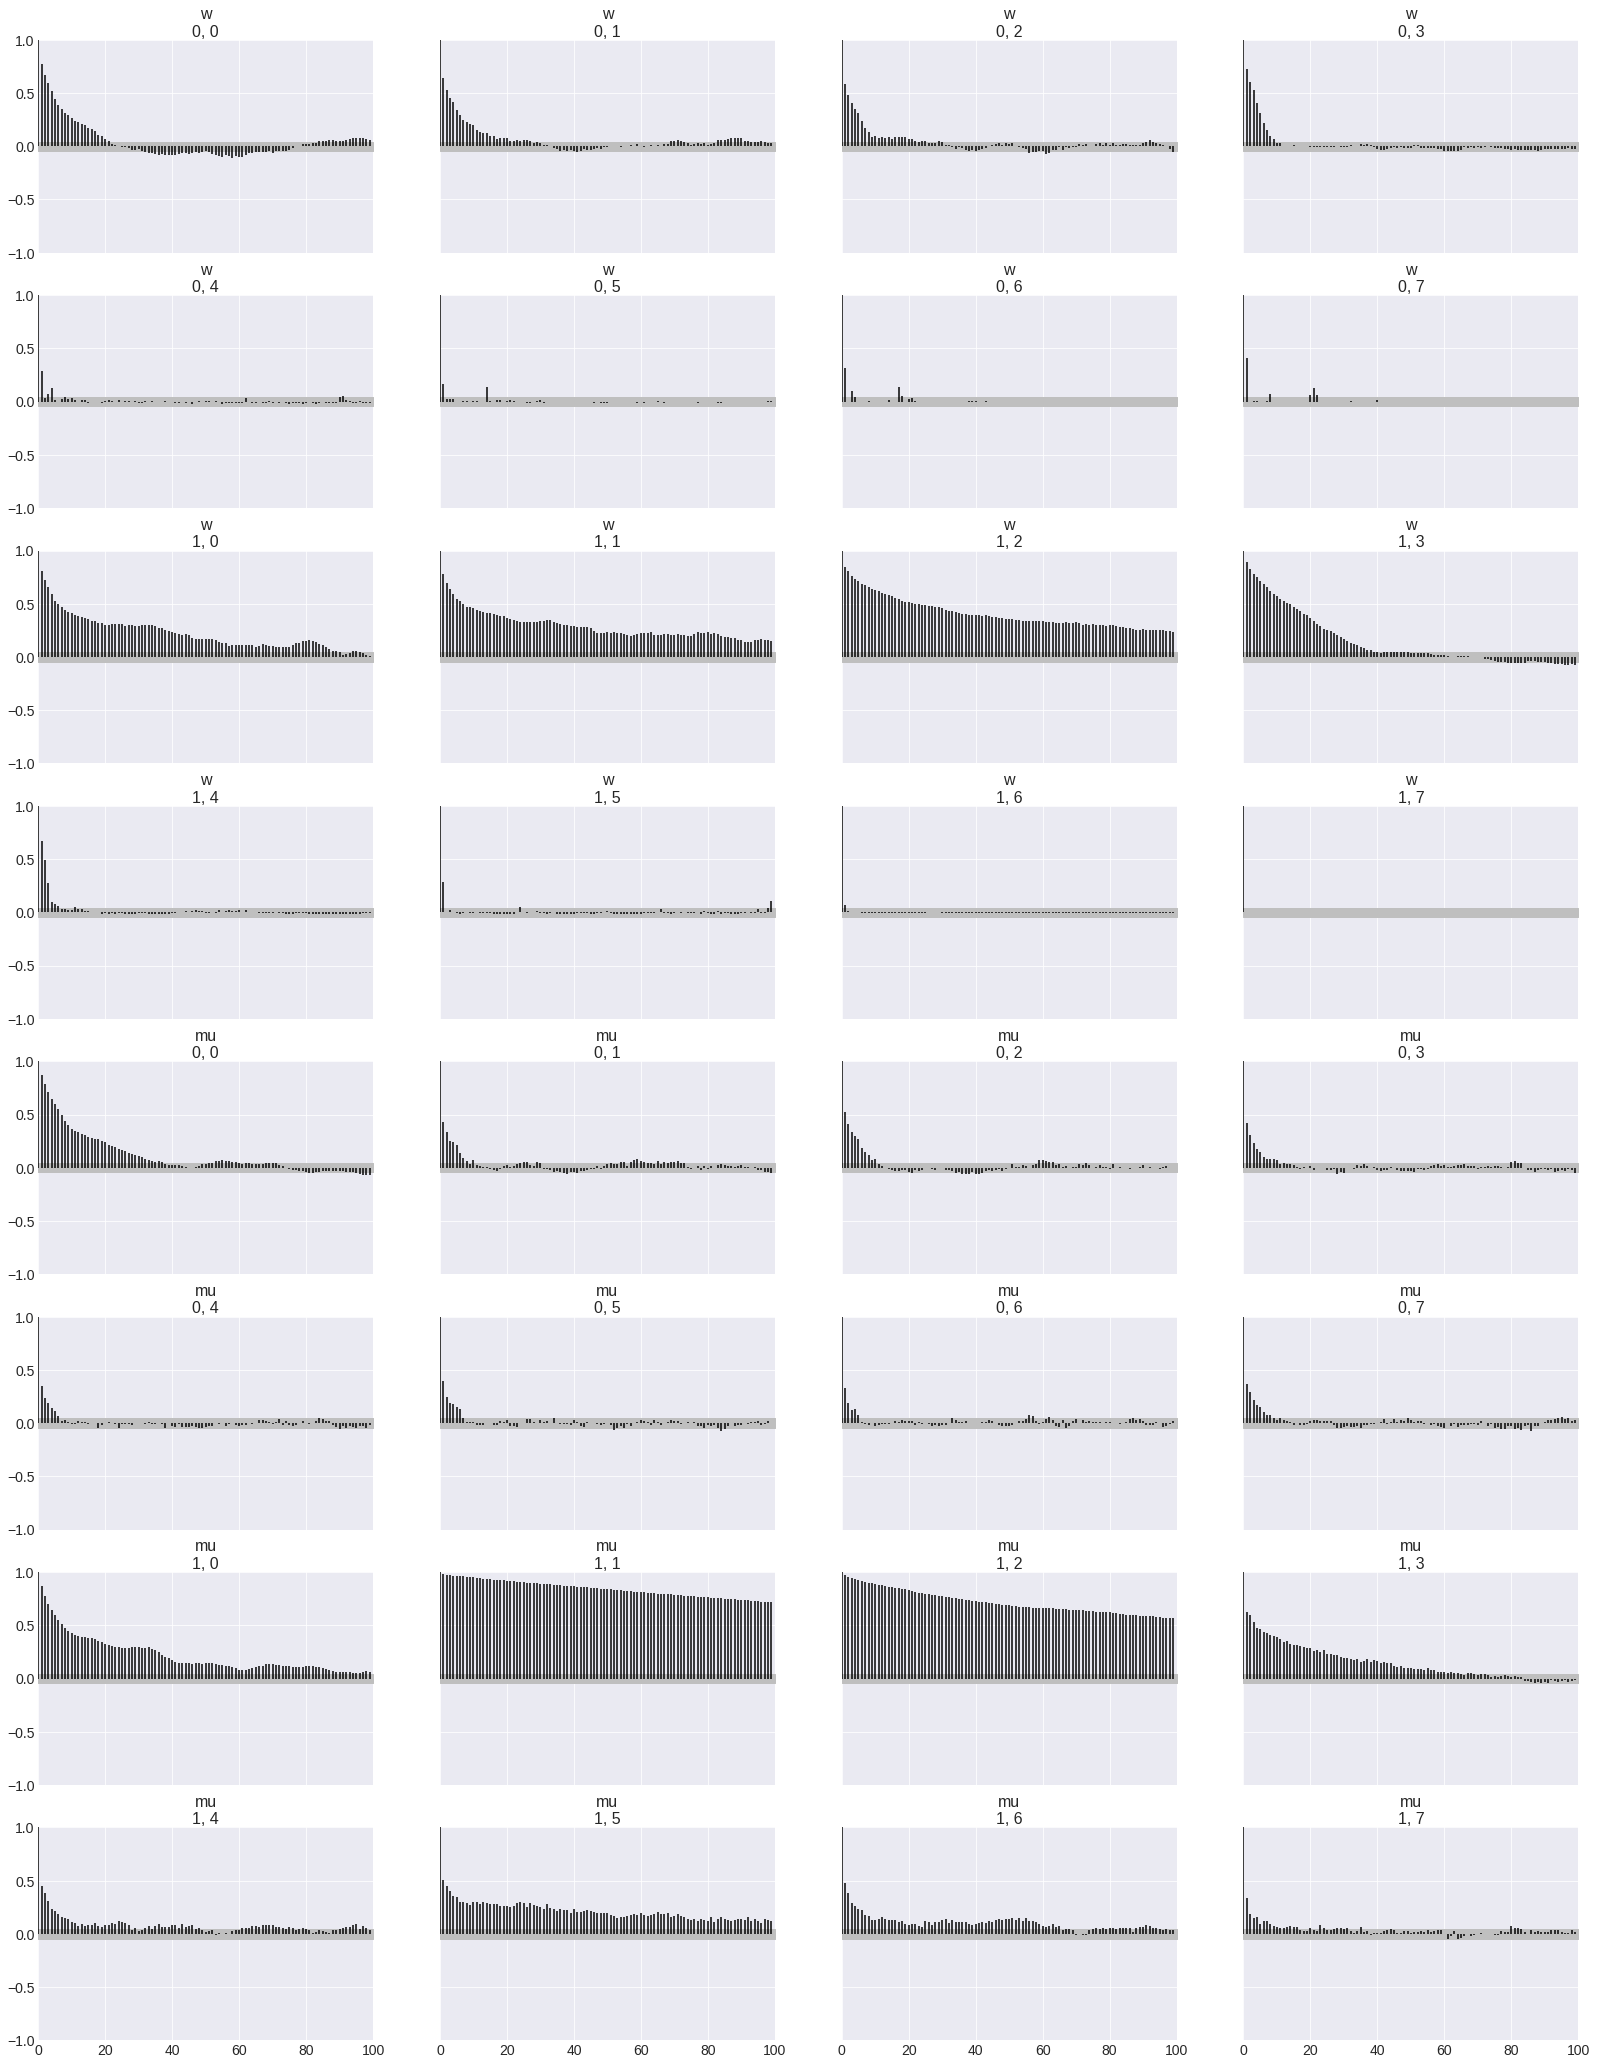

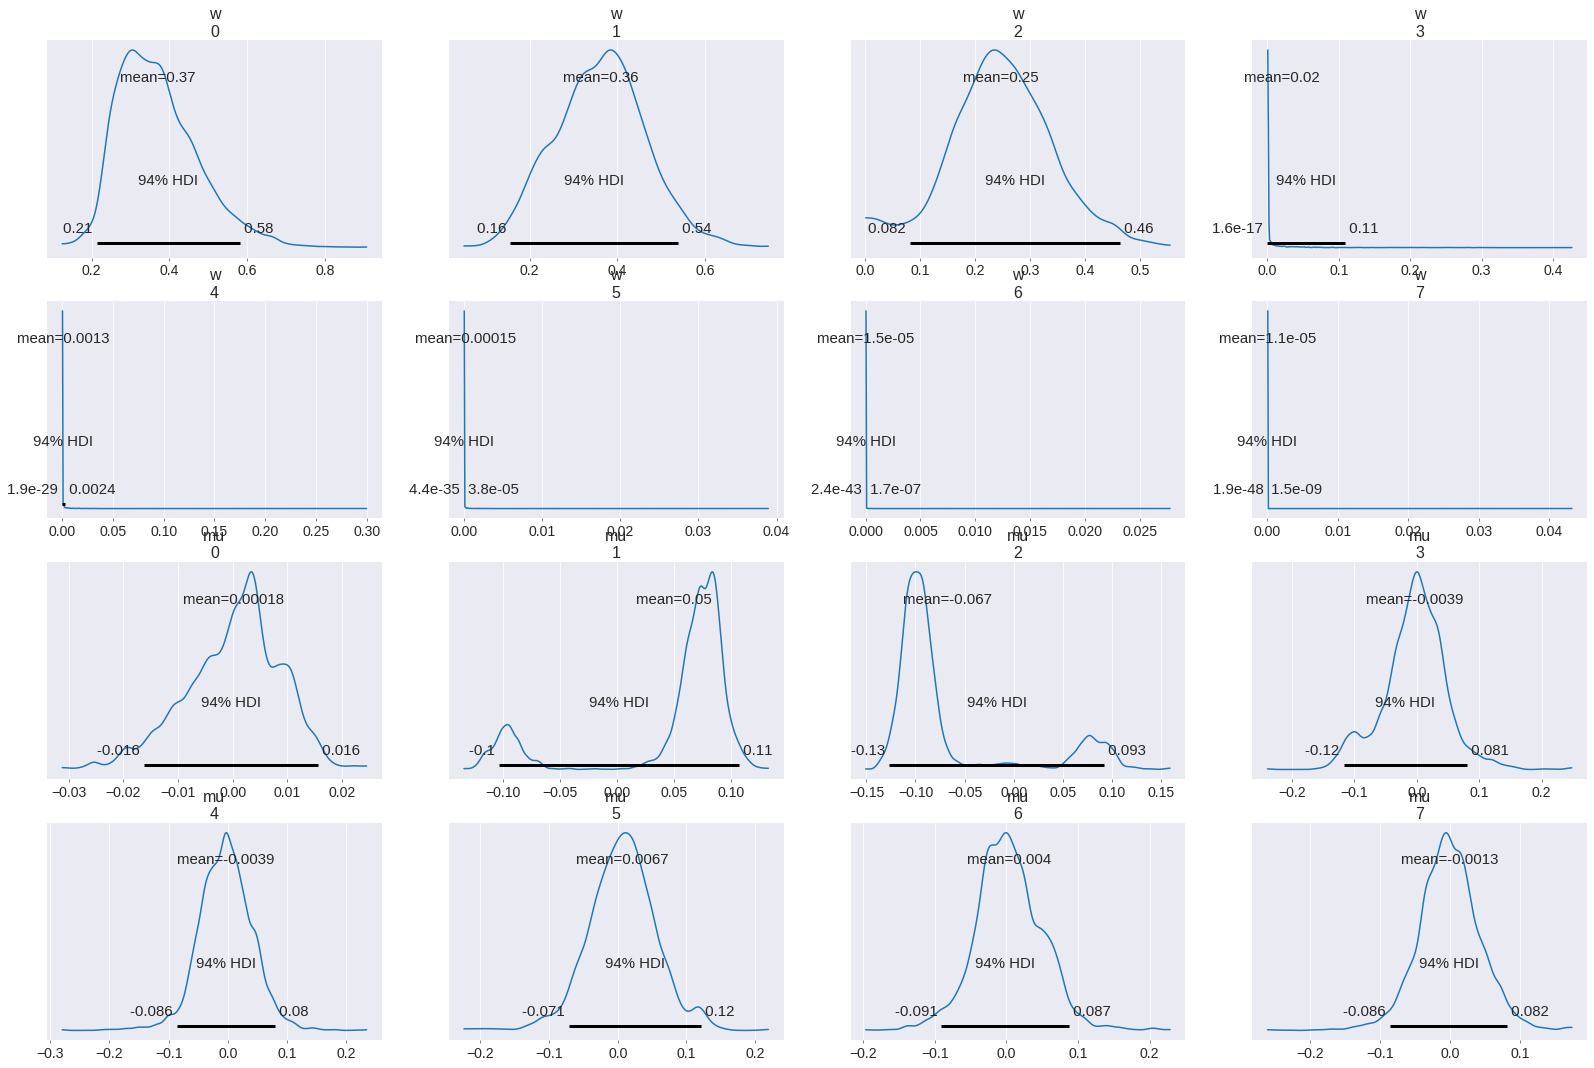

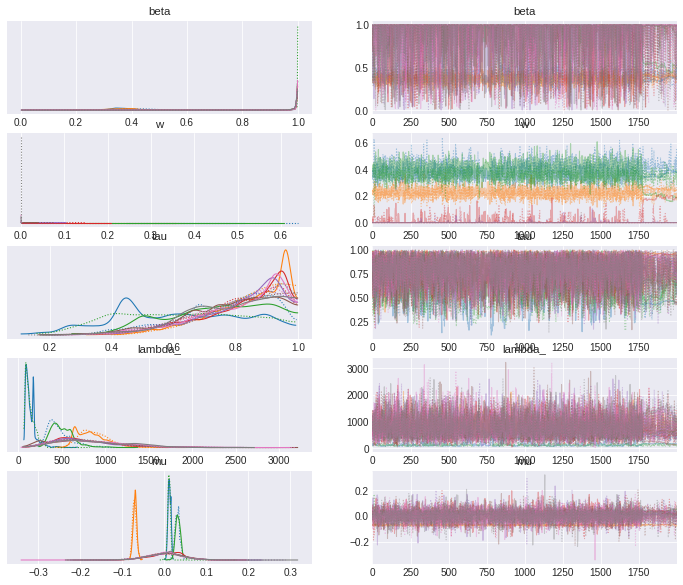

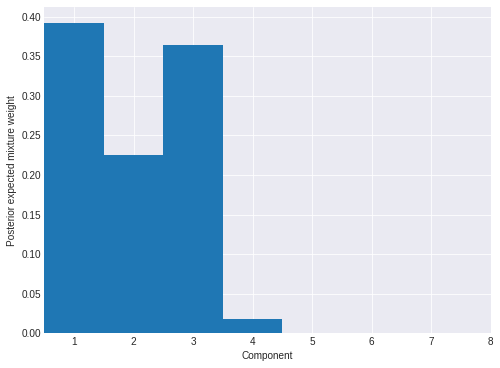

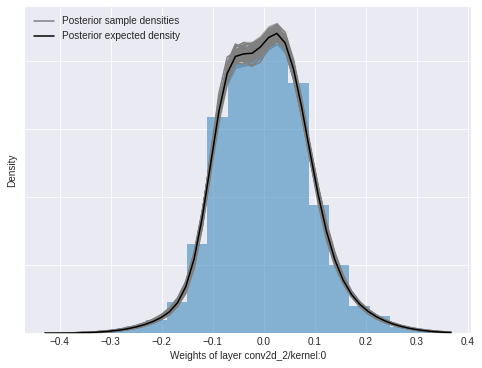

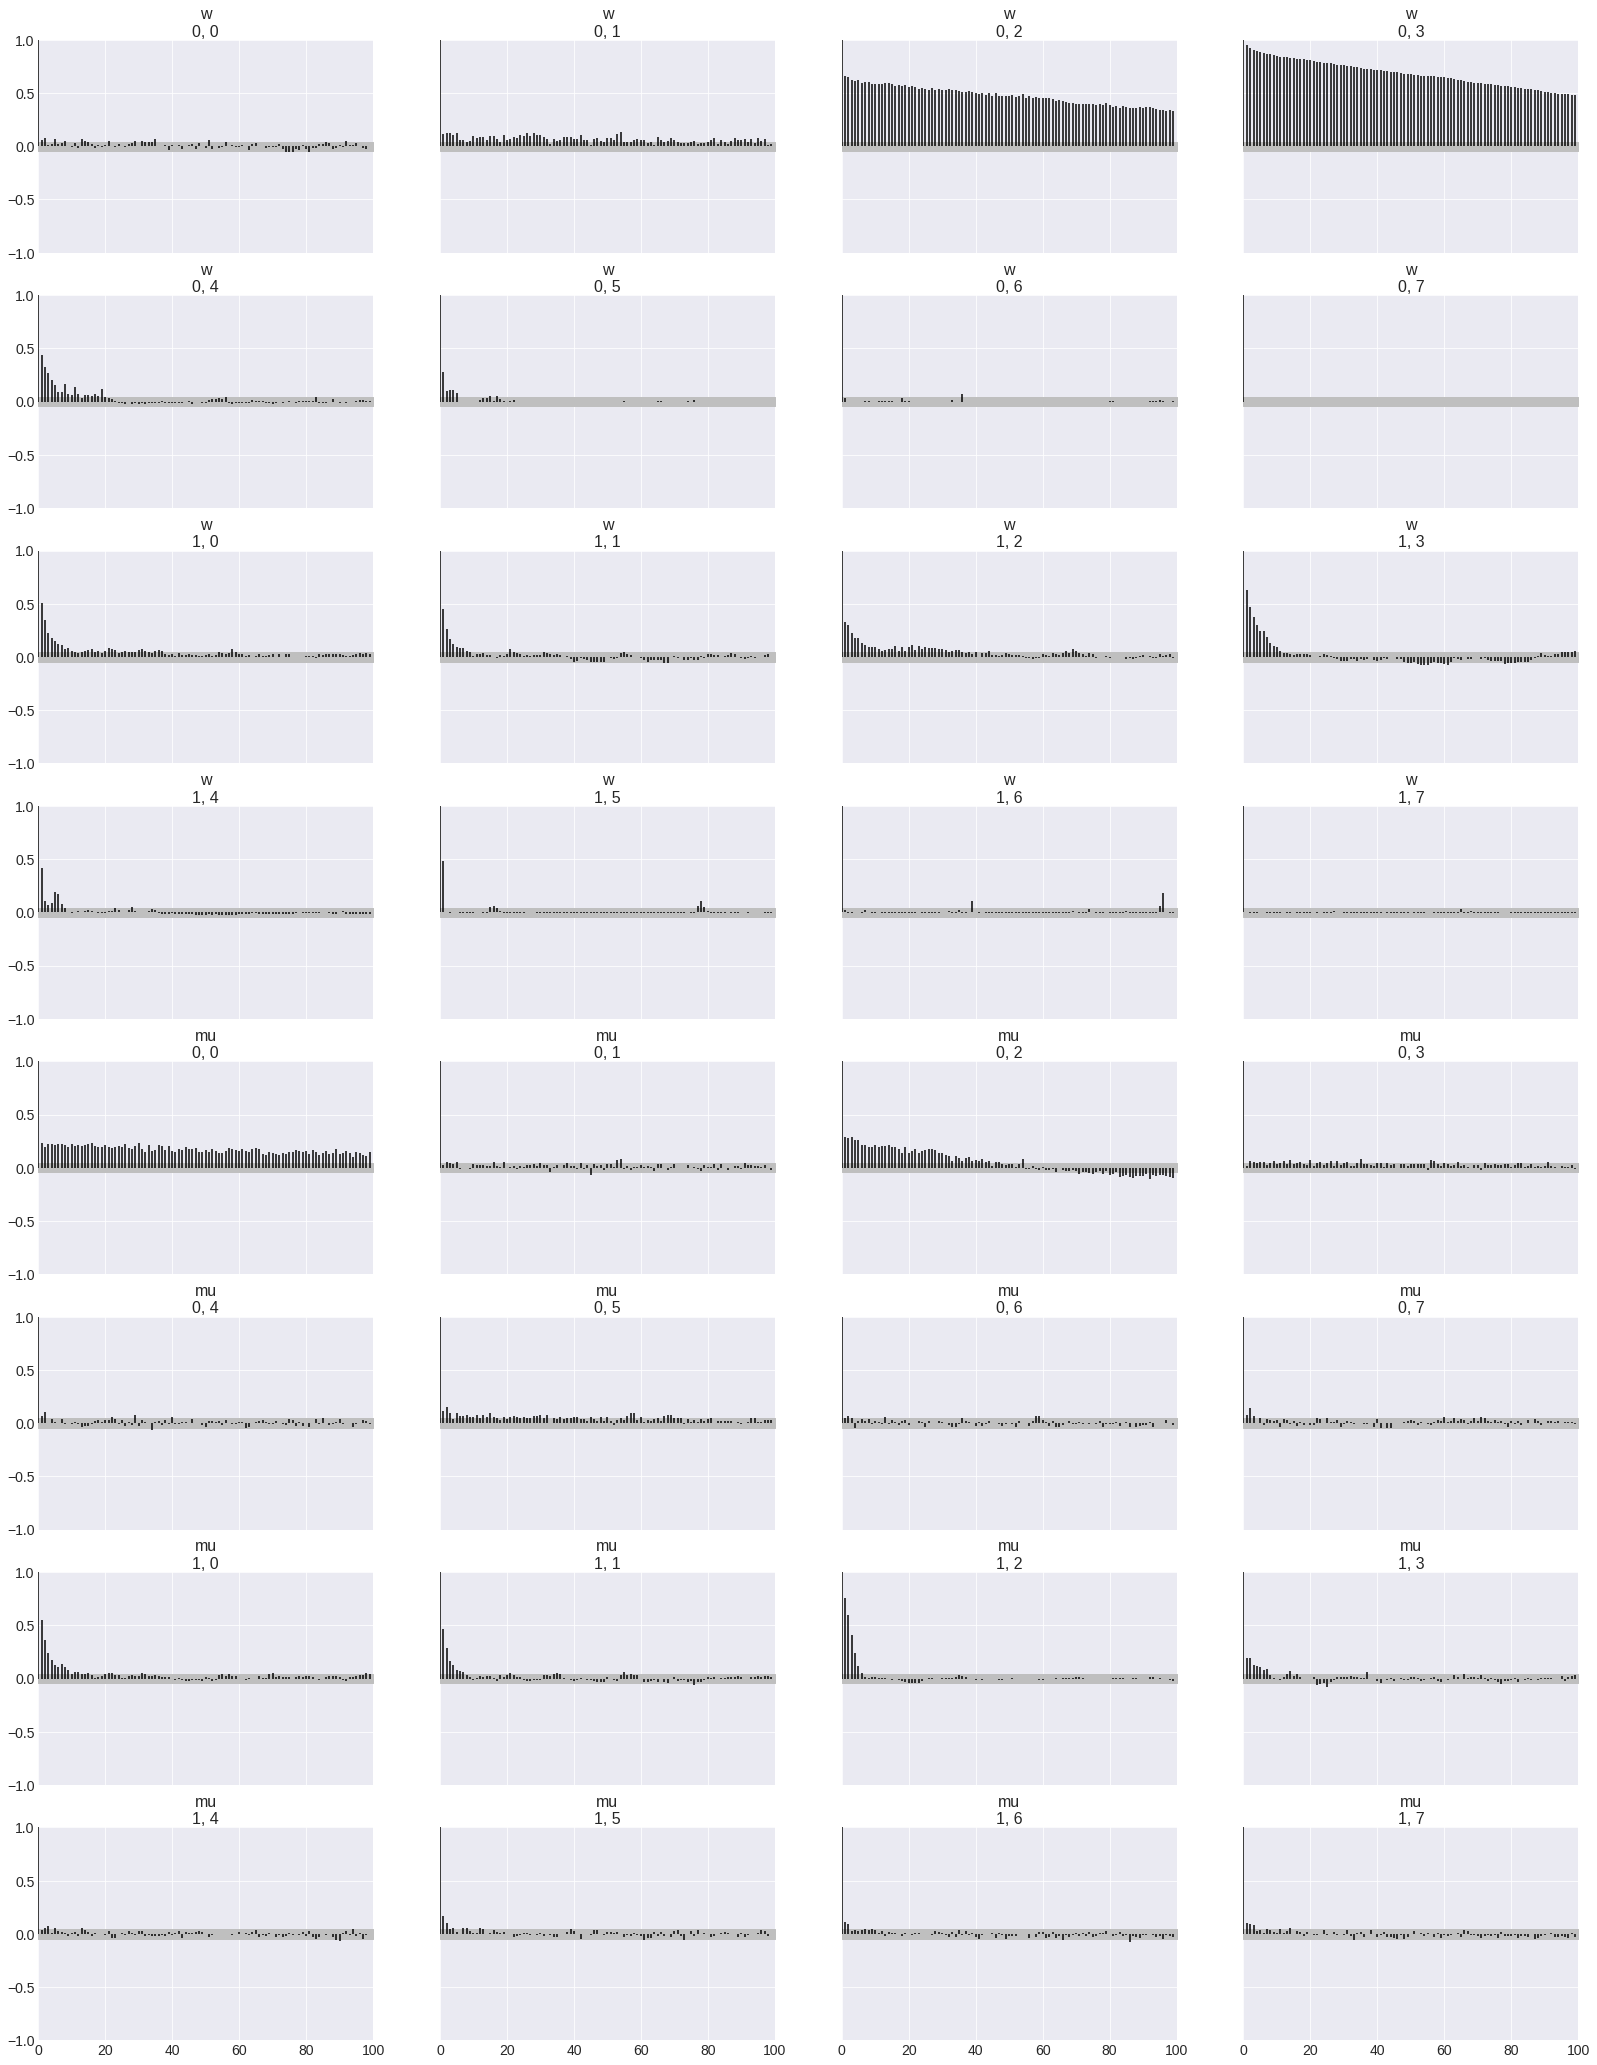

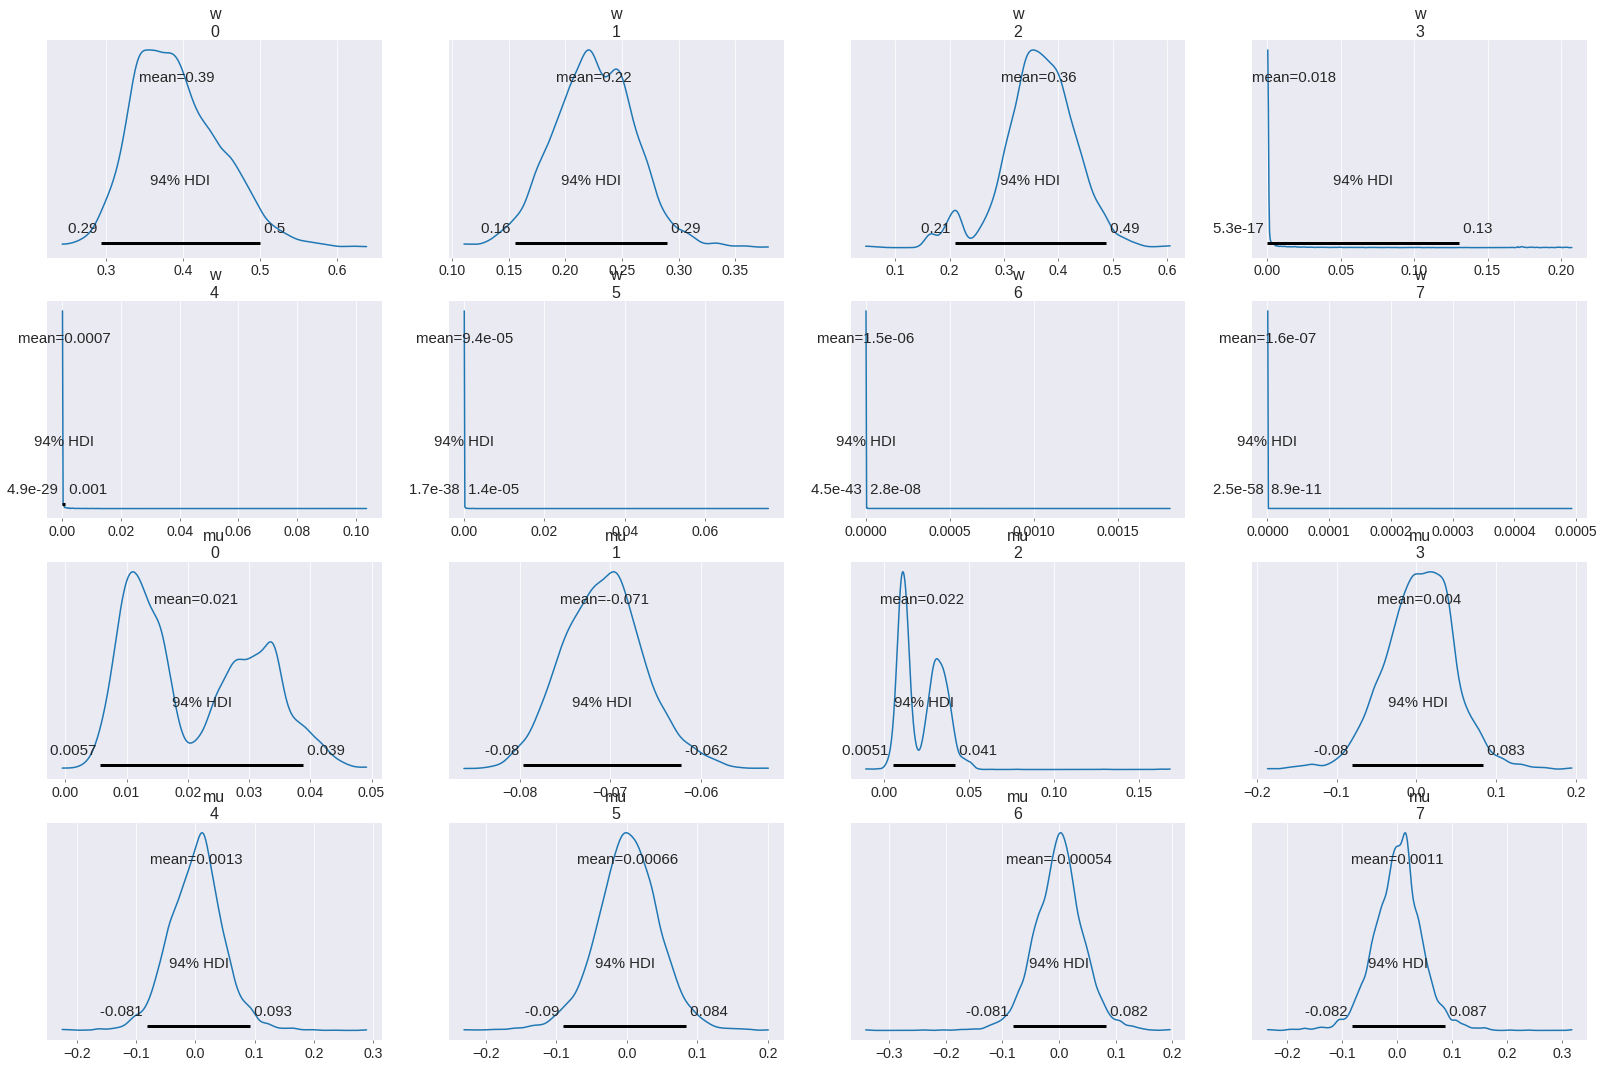

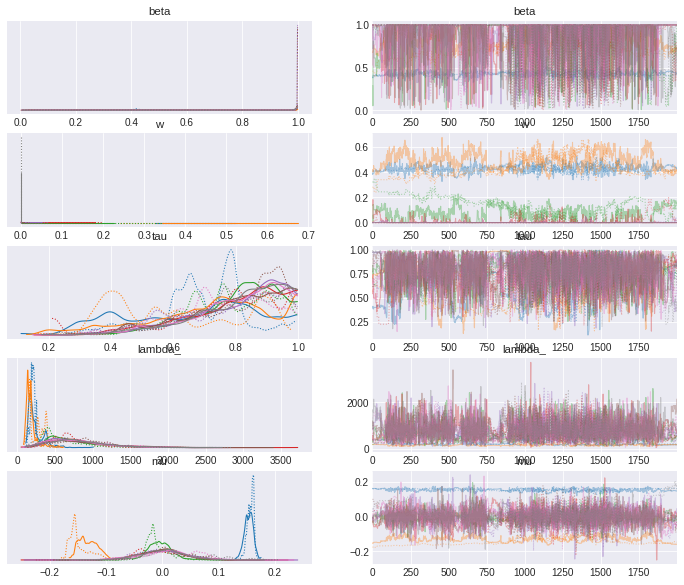

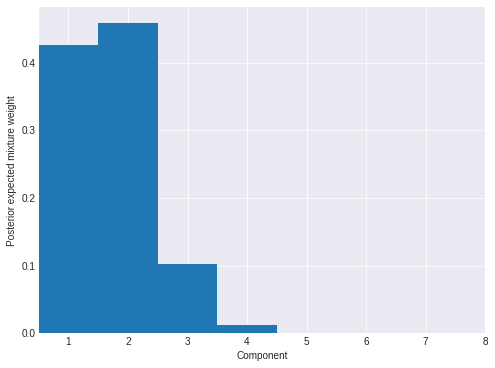

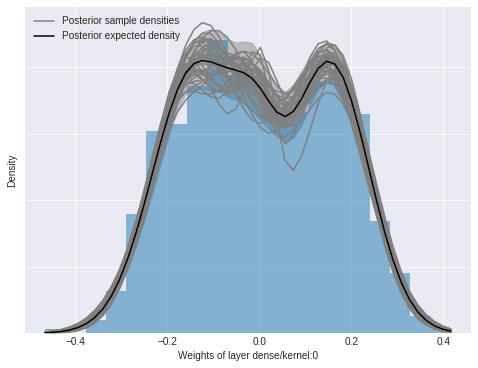

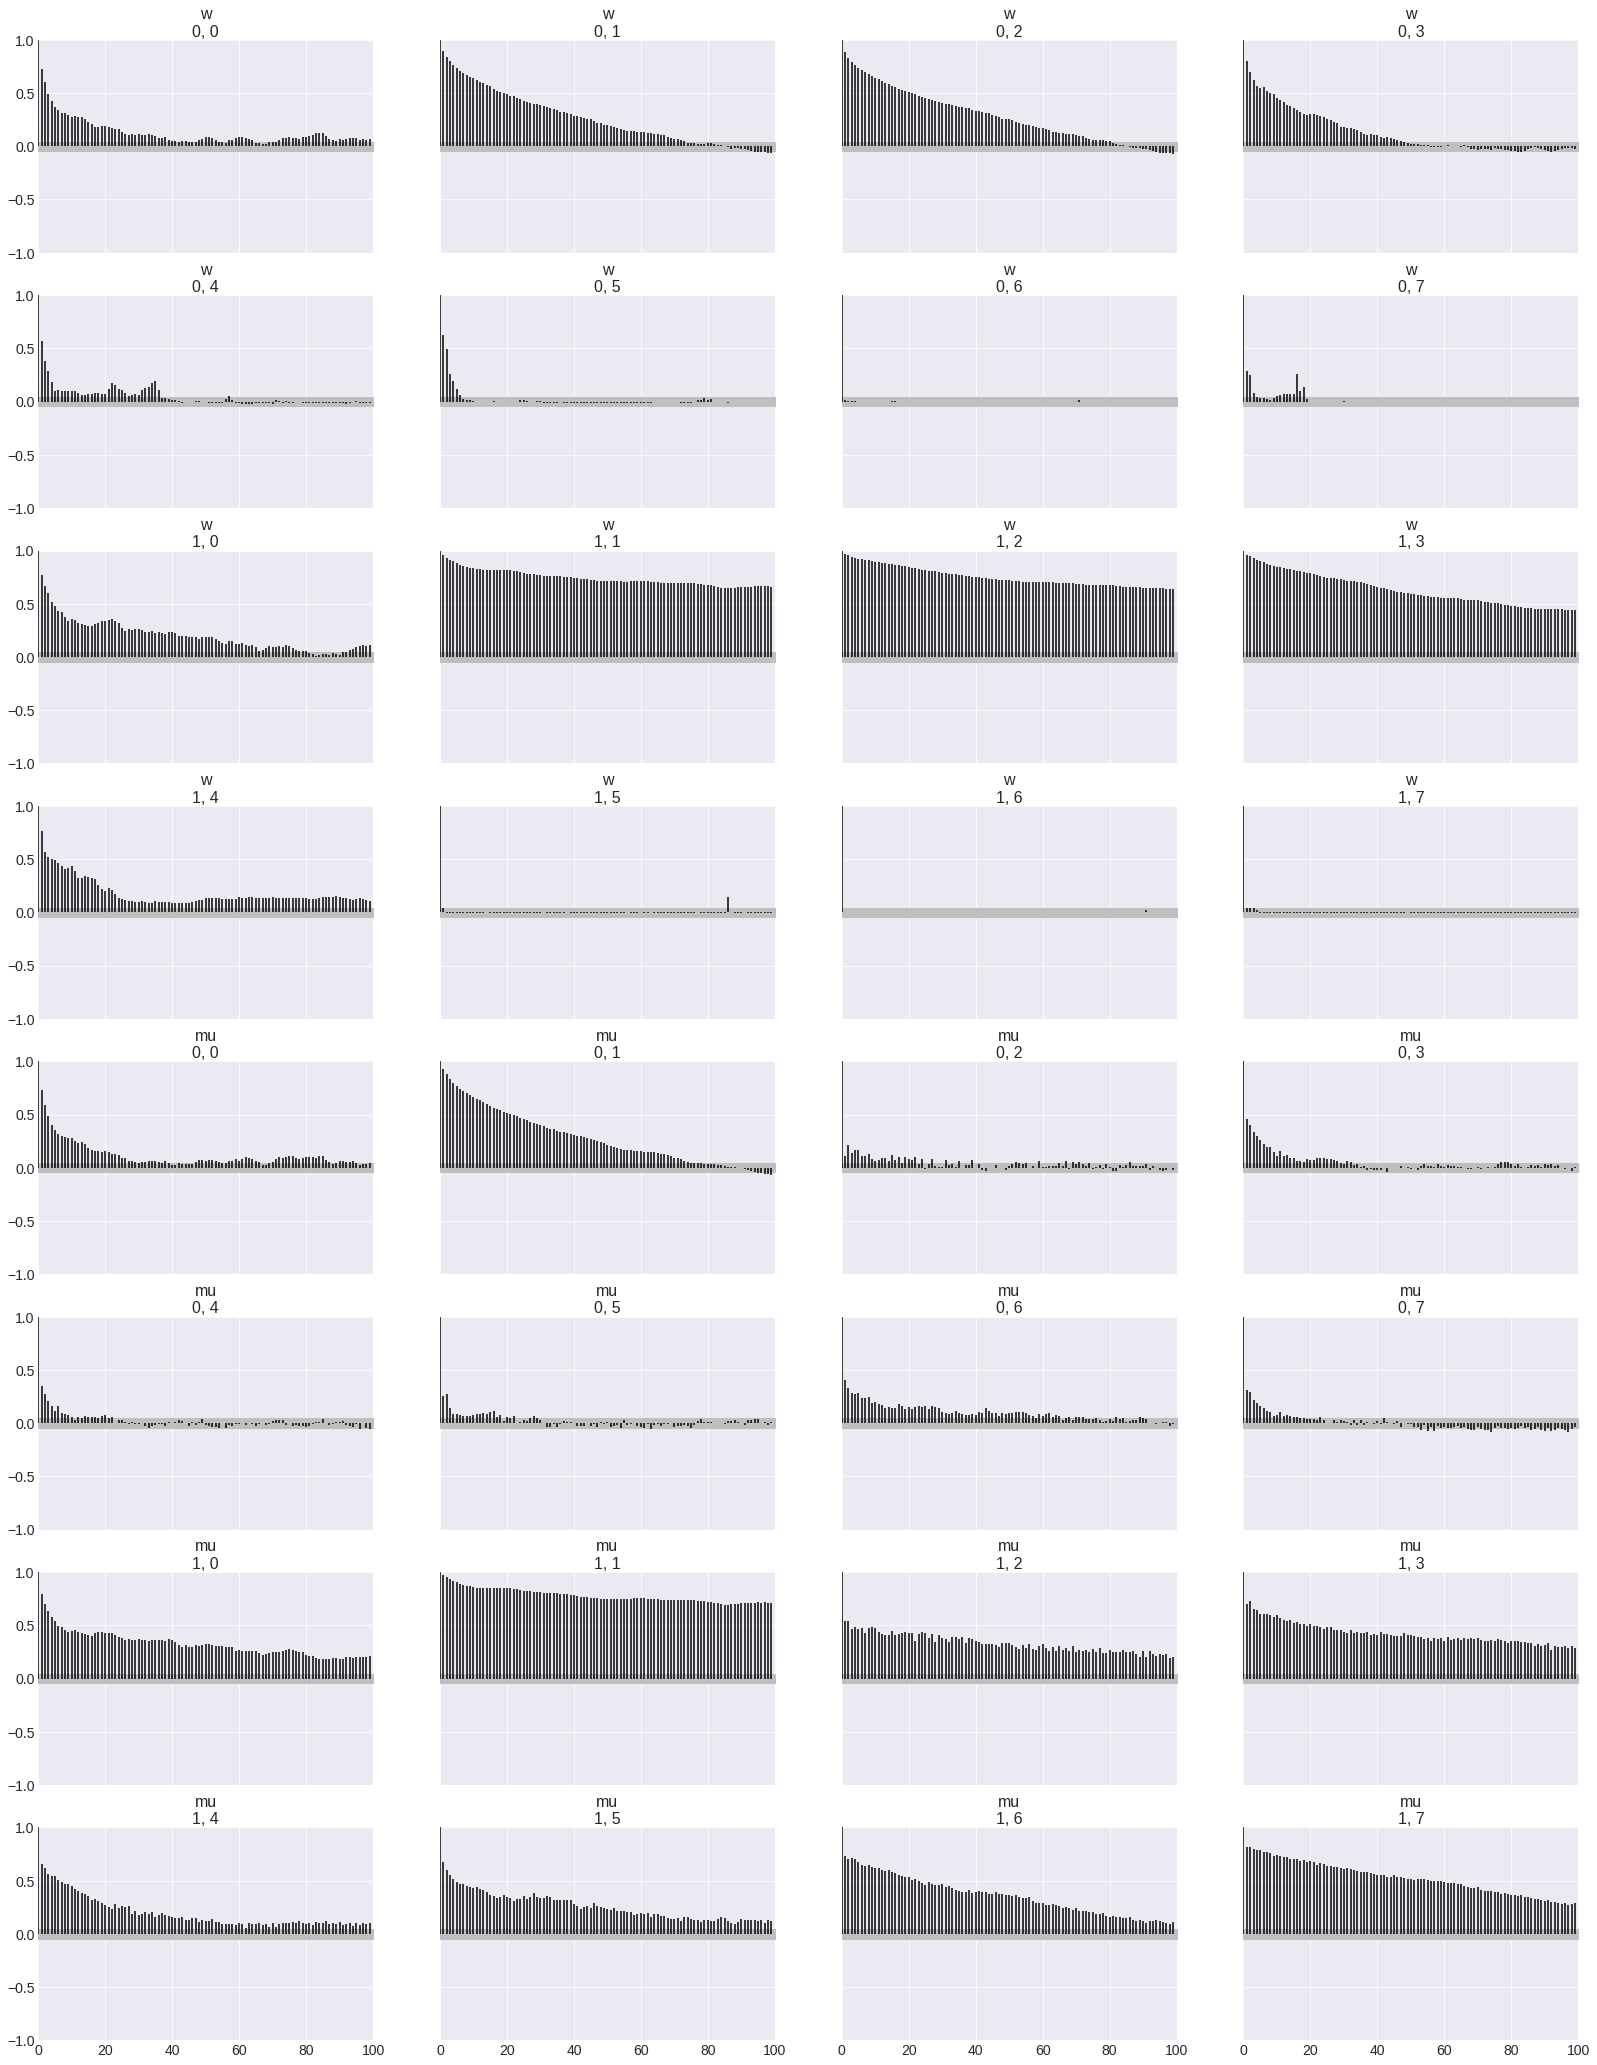

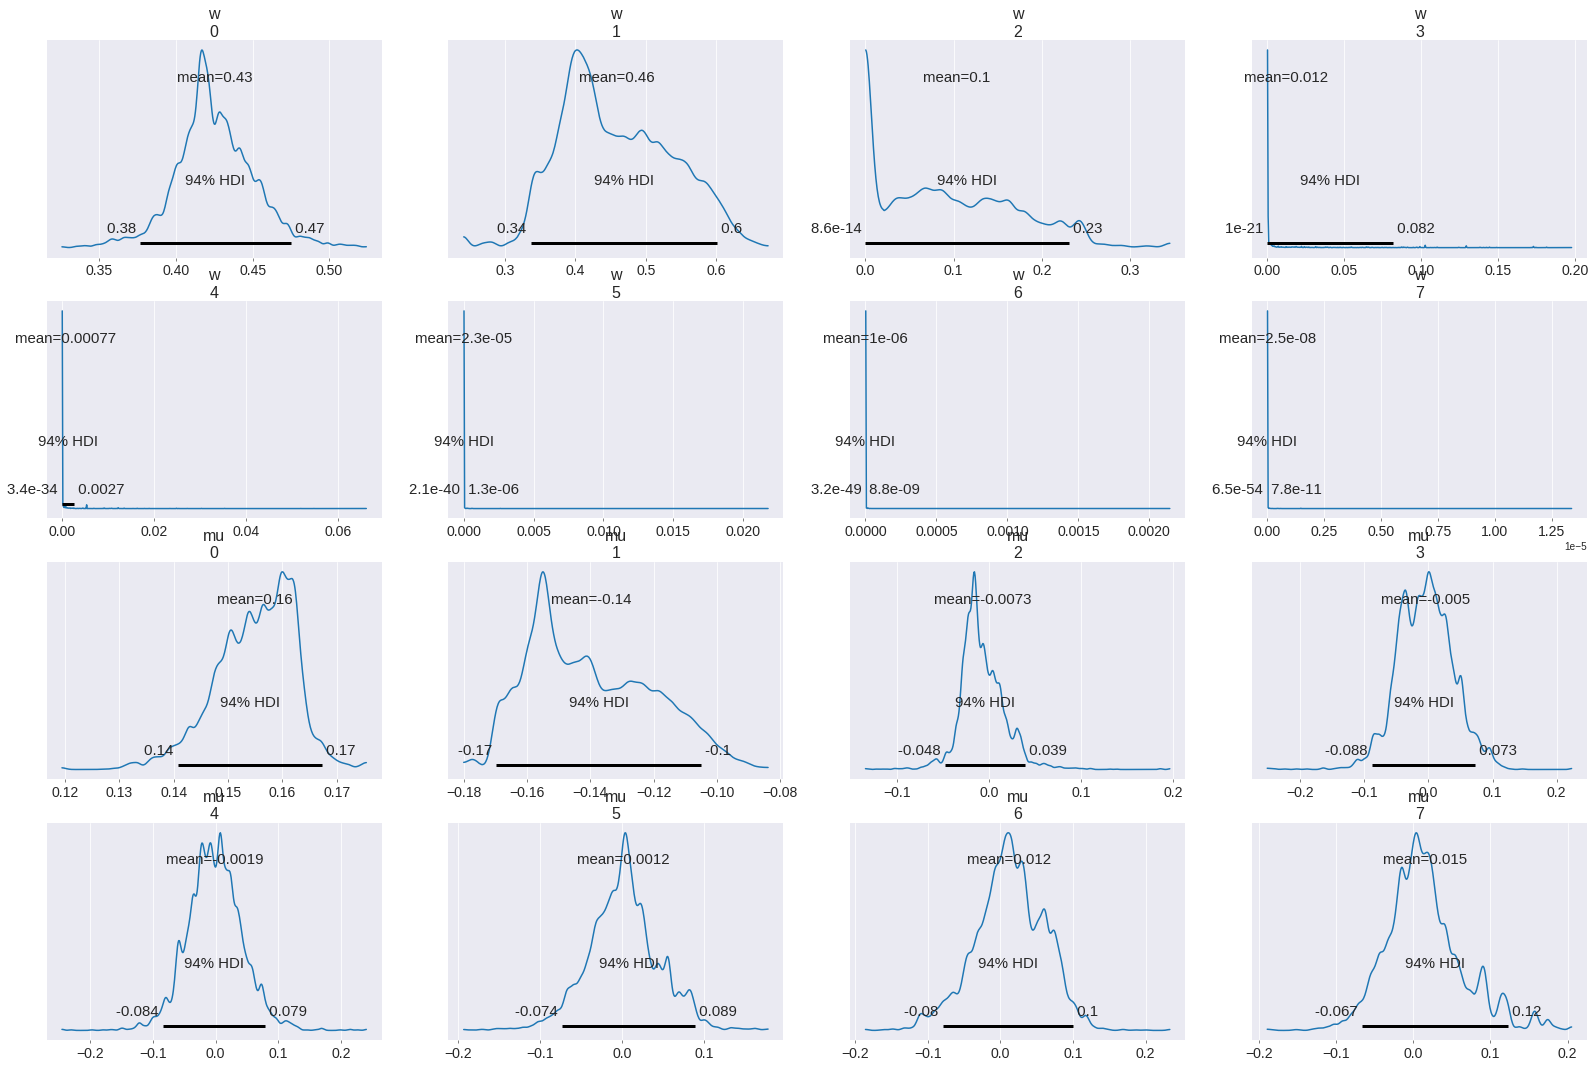

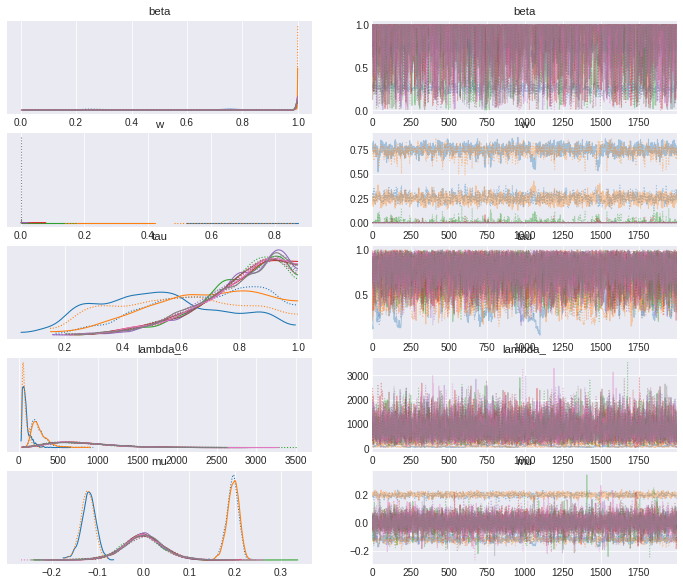

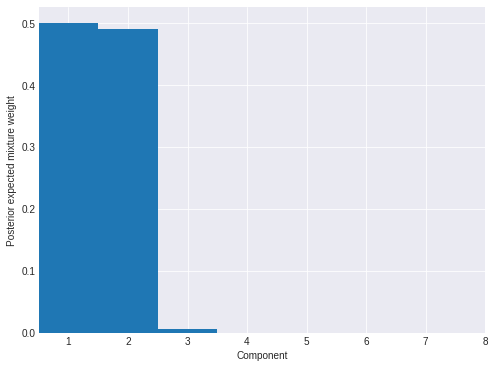

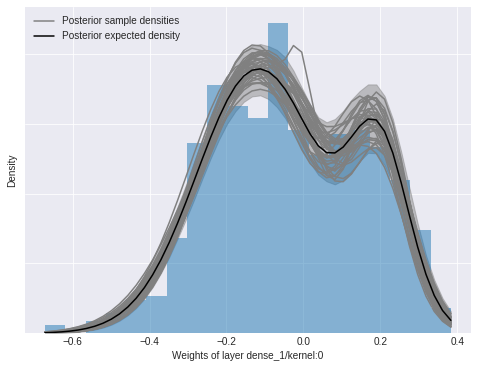

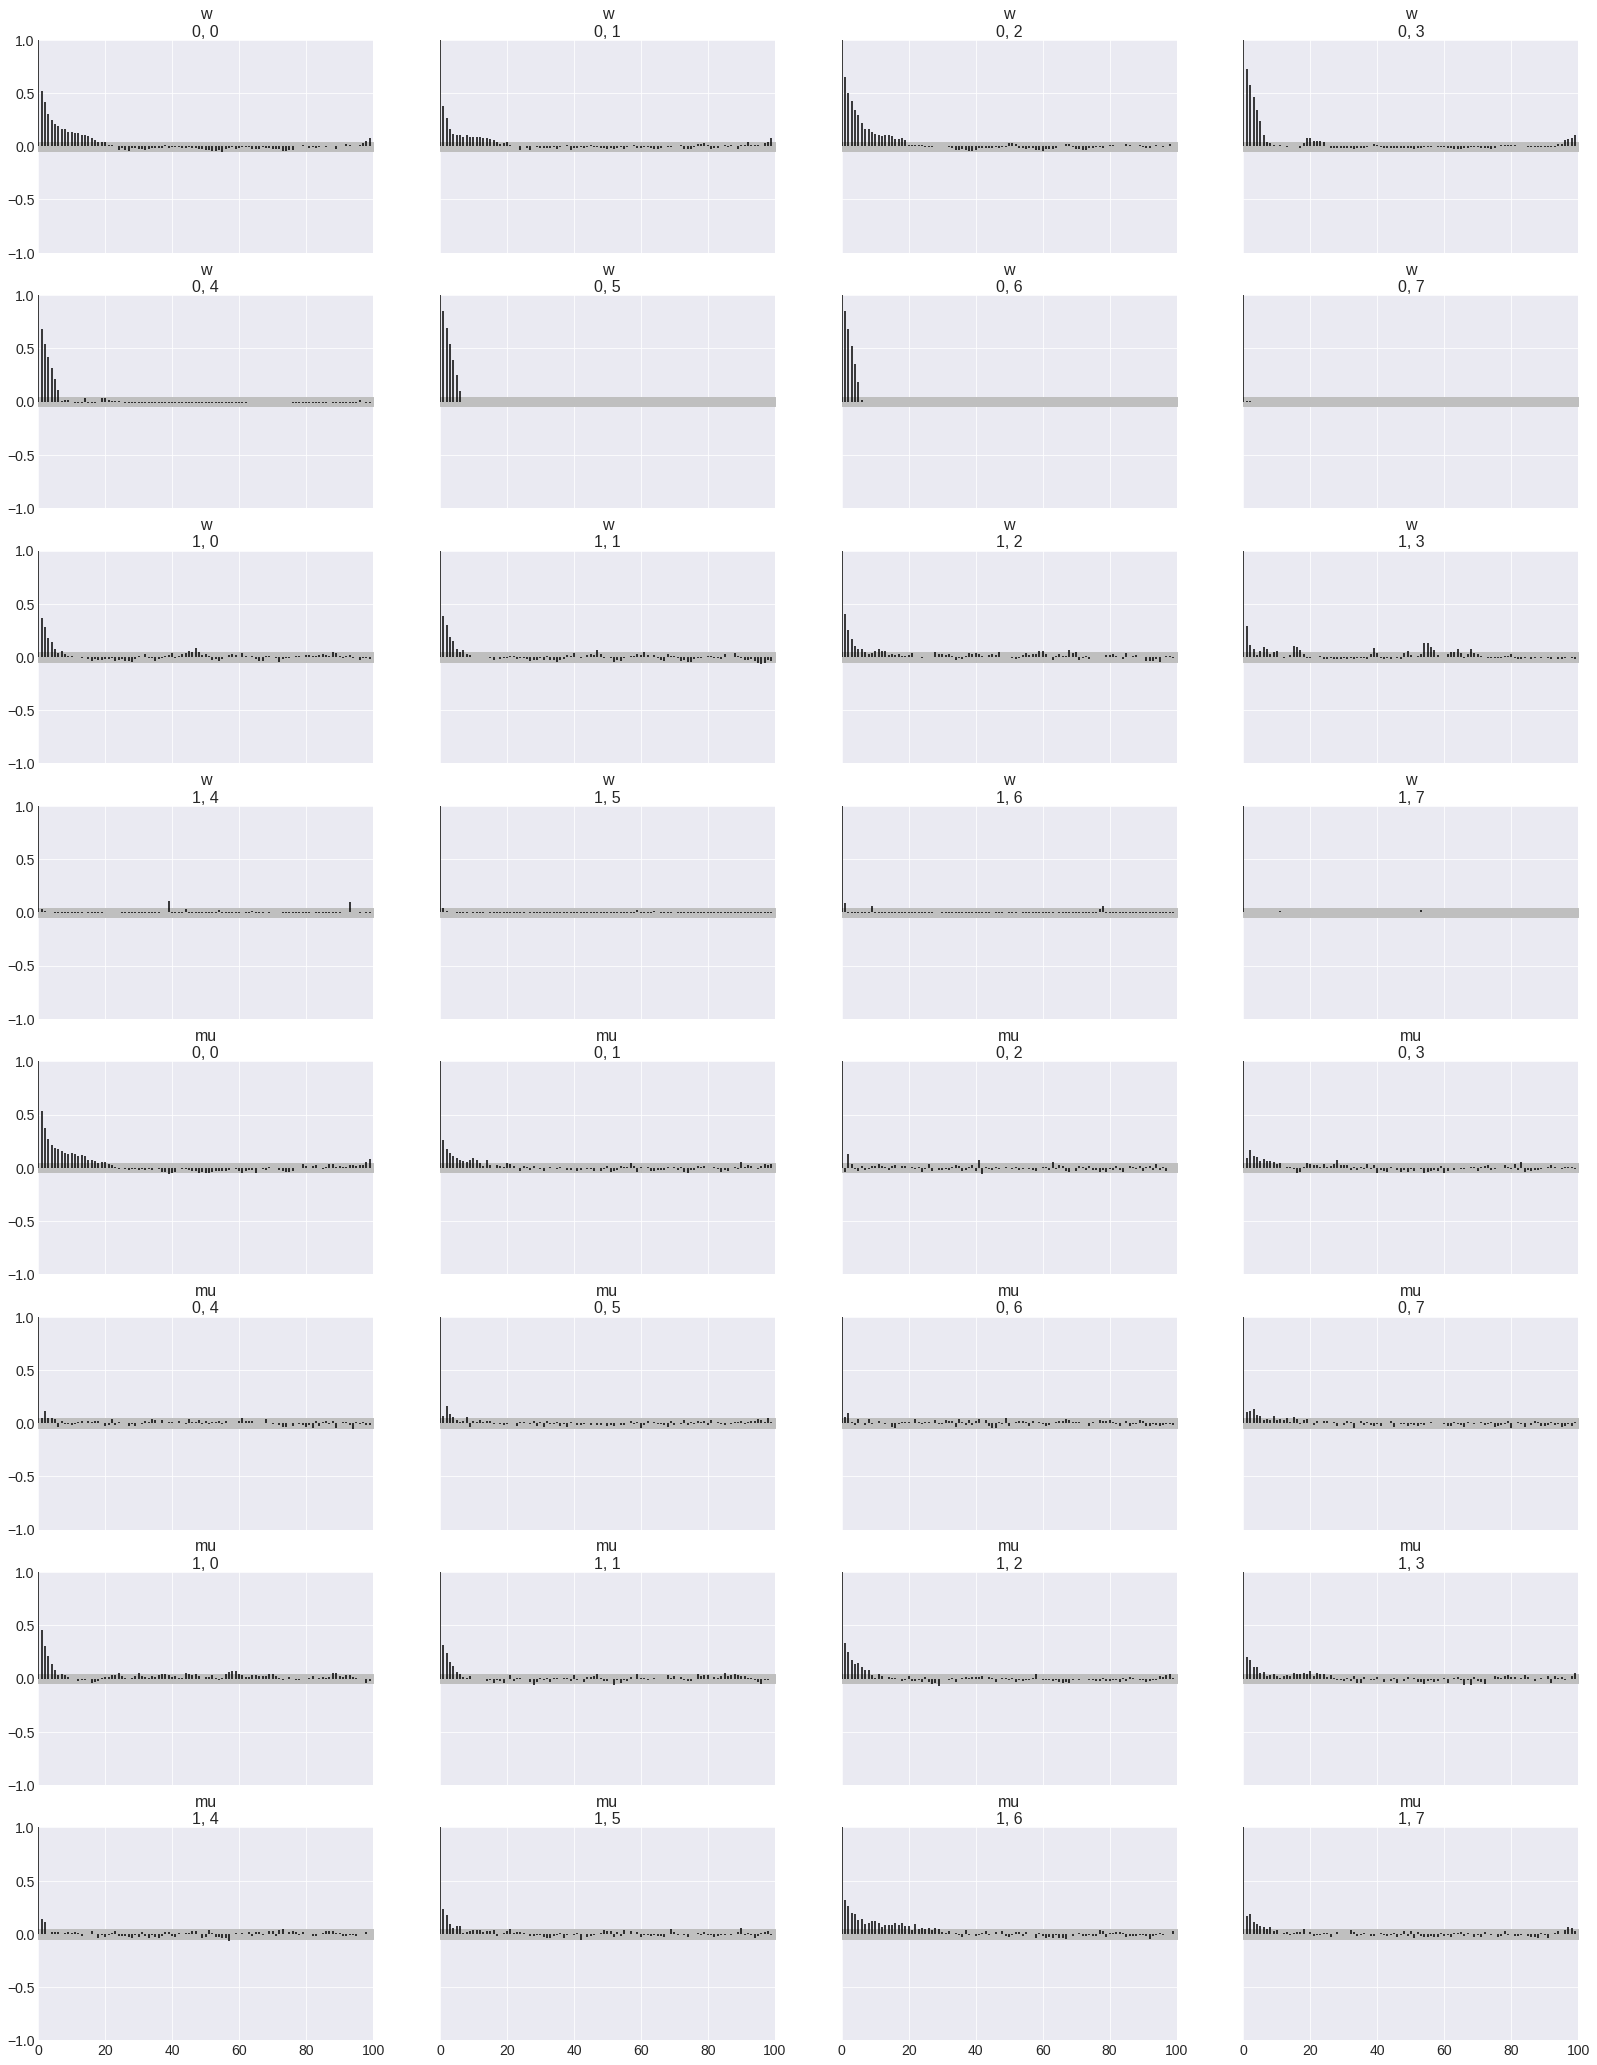

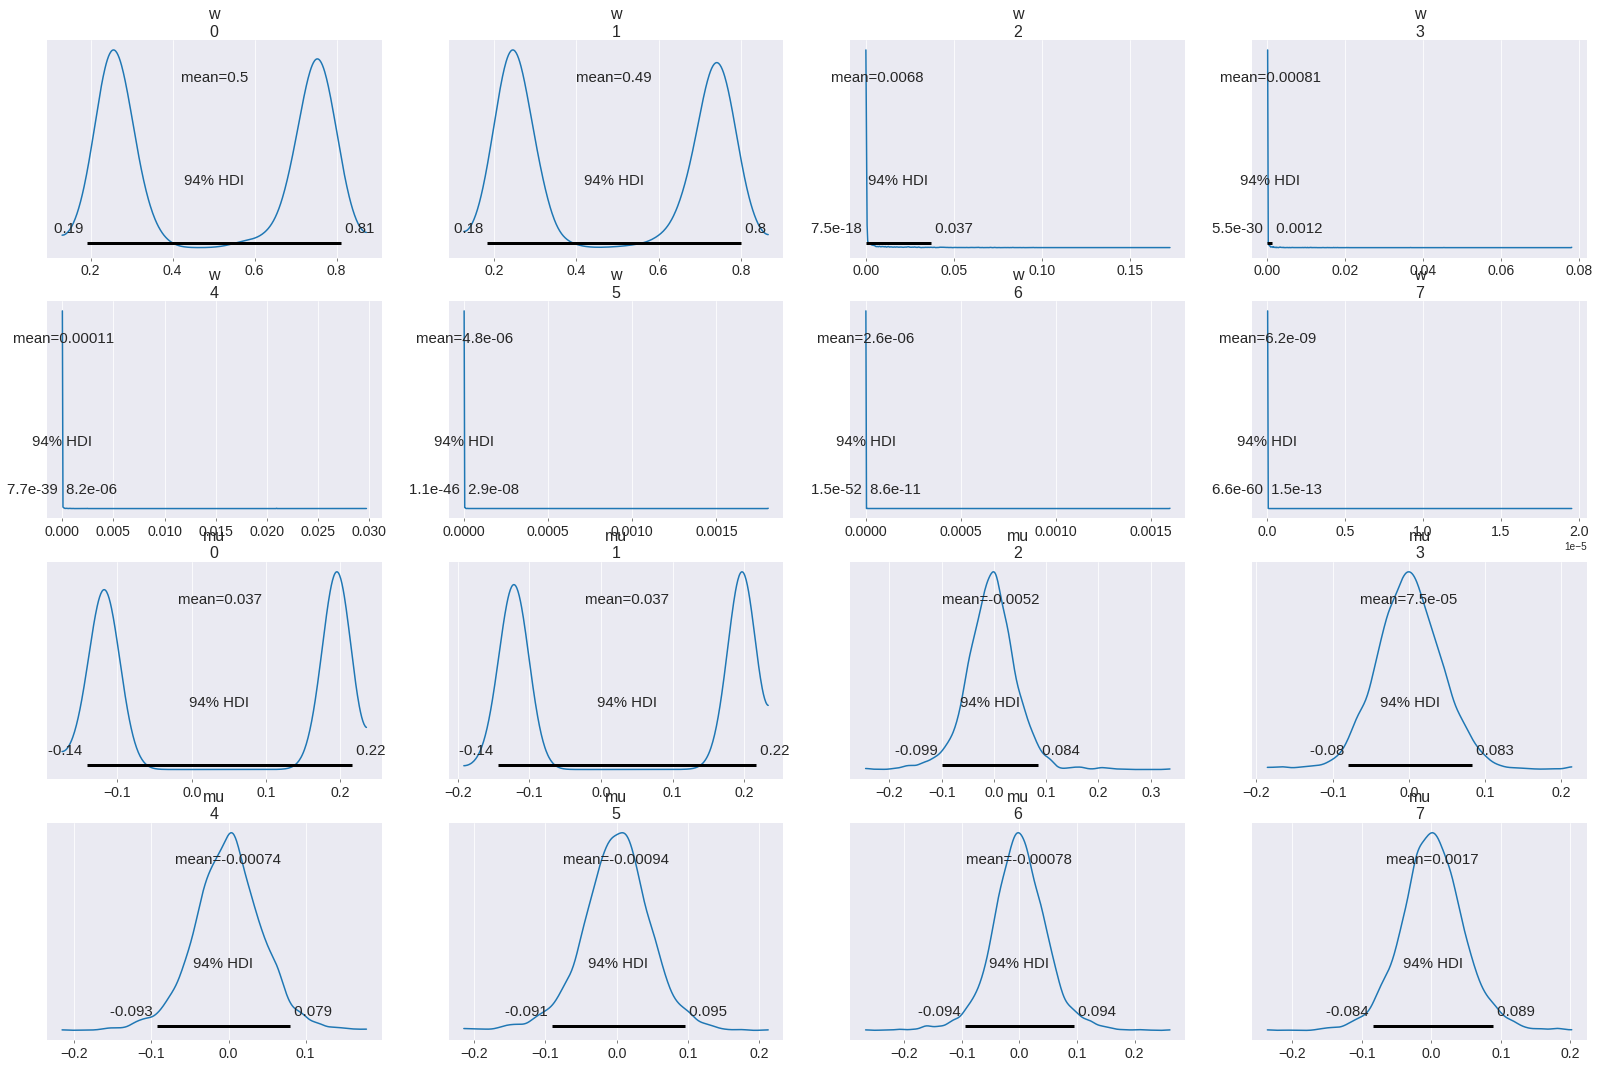

In [16]:
clustered_model = _cluster_weights(model)

In [17]:
print('Saving model...')
tf.keras.models.save_model(clustered_model, "clustered_model", include_optimizer=False)
tf.keras.models.save_model(model, "model", include_optimizer=False)
# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.SparseCategoricalAccuracy()]
)

clustered_model.summary()

Saving model...


INFO:tensorflow:Assets written to: clustered_model/assets


INFO:tensorflow:Assets written to: clustered_model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d (ClusterWeig  (None, 28, 28, 1)        616       
 hts)                                                            
                                                                 
 cluster_max_pooling2d (Clus  (None, 28, 28, 1)        0         
 terWeights)                                                     
                                                                 
 cluster_conv2d_1 (ClusterWe  (None, 28, 28, 1)        8232      
 ights)                                                          
                                                                 
 cluster_max_pooling2d_1 (Cl  (None, 28, 28, 1)        0         
 usterWeights)                                                   
                                                                 
 cluster_conv2d_2 (ClusterWe  (None, 28, 28, 1)        1

In [18]:
_, baseline_model_accuracy, baseline_sparse_categorical = model.evaluate(
  x_test, y_test, verbose=0)

In [31]:
clustered_model.fit(
  x_train, 
  y_train,
  batch_size=500,
  epochs=2,
  validation_split=0.1)

Epoch 1/2
108/108 [==============================] - 20s 186ms/step - loss: 0.6137 - accuracy: 0.8054 - sparse_categorical_accuracy: 0.8054 - val_loss: 0.3696 - val_accuracy: 0.8843 - val_sparse_categorical_accuracy: 0.8843
Epoch 2/2
108/108 [==============================] - 17s 162ms/step - loss: 0.3404 - accuracy: 0.8927 - sparse_categorical_accuracy: 0.8927 - val_loss: 0.2263 - val_accuracy: 0.9315 - val_sparse_categorical_accuracy: 0.9315


In [32]:
_, clustered_model_accuracy, clustered_sparse_categorical = clustered_model.evaluate(
  x_test, y_test, verbose=0)

In [33]:
print(f"Baseline test accuracy: {baseline_model_accuracy:.3f}")
print(f"Clustered test accuracy: {clustered_model_accuracy:.3f}")

Baseline test accuracy: 0.985
Clustered test accuracy: 0.921


In [42]:
!unzip clustered_model.zip
!unzip model.zip

Archive:  model.zip
   creating: model/
   creating: model/variables/
  inflating: model/variables/variables.index  
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/saved_model.pb    
   creating: model/assets/
  inflating: model/keras_metadata.pb  


In [36]:
clustered_model = keras.models.load_model('clustered_model')

In [37]:
final_model = tfmot.clustering.keras.strip_clustering(clustered_model)

In [40]:
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_clustered_model = converter.convert()
with open("clustered_model.tflite", "wb") as f:
  f.write(tflite_clustered_model)
print("Saved clustered TFLite model to: clustered_model.tflite")

INFO:tensorflow:Assets written to: /tmp/tmpjl4jsteu/assets


INFO:tensorflow:Assets written to: /tmp/tmpjl4jsteu/assets


Saved clustered TFLite model to: clustered_model.tflite


In [44]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in bytes.
  import os
  import zipfile
  import tempfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [53]:
print(f"Size of gzipped baseline Keras model: {get_gzipped_model_size('model.zip'):.2f} bytes")
print(f"Size of gzipped clustered Keras model: {get_gzipped_model_size('clustered_model.tflite'):.2f} bytes")

Size of gzipped baseline Keras model: 3448.00 bytes
Size of gzipped clustered Keras model: 420.00 bytes


#Prototyping space

In [10]:
conv_layers = [layer for layer in model.layers if "conv" in layer.name]
unrolled_weights = tf.reshape(conv_layers[0].weights[0], shape=[-1])

In [11]:
K_thres = 15
samples = 1000
chains = 2
def stick_breaking(beta):
  portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
  return beta * portion_remaining

In [74]:
with pm.Model() as dpm_model:
    alpha = Gamma("alpha", 5., 2.)
    beta = Beta("beta", 1., alpha, shape=K_thres)
    w = Deterministic("w", stick_breaking(beta))

    tau = Beta("tau", .25, .5, shape=K_thres)
    lambda_ = Gamma("lambda_", 20.0, 1.0, shape=K_thres)
    mu = Bound(Normal, lower=-1., upper=1.)("mu", 0.0, tau=tau * lambda_, shape=K_thres)

    obs = NormalMixture("obs", w, mu, tau = tau * lambda_, observed=unrolled_weights, shape = K_thres)

    idata = pm.sample(
      samples, 
      tune = 1500,
      chains = chains,#self.no_chains,
      init = "advi",
      target_accept=0.9,
      return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 22800
Interrupted at 22,799 [11%]: Average Loss = 15.245
Sequential sampling (2 chains in 1 job)
NUTS: [mu, lambda_, tau, beta]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 67 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [75]:
mixture_params = idata.posterior[["w", "mu", "lambda_", "tau"]].mean(("chain", "draw"))

trace_w = np.reshape(idata.posterior["w"].values, [samples*chains, K_thres])
trace_mu = np.reshape(idata.posterior["mu"].values, [samples*chains, K_thres])
trace_lambda = np.reshape(idata.posterior["lambda_"].values, [samples*chains, K_thres])
trace_tau = np.reshape(idata.posterior["tau"].values, [samples*chains, K_thres])

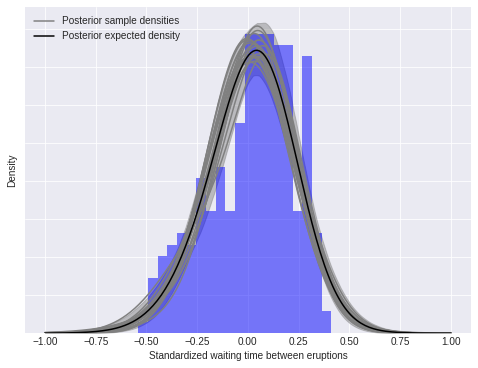

In [76]:
x_plot = np.linspace(-1, 1, 200)

post_pdf_contribs = sp.stats.norm.pdf(
    np.atleast_3d(x_plot),
    trace_mu[:, np.newaxis, :],
    1.0 / np.sqrt(trace_lambda * trace_tau)[:, np.newaxis, :]
)
post_pdfs = (trace_w[:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(8, 6))


n_bins = 20
ax.hist(unrolled_weights, bins=n_bins, density=True, color="blue", lw=0, alpha=0.5)

ax.fill_between(x_plot, post_pdf_low, post_pdf_high, color="gray", alpha=0.45)
ax.plot(x_plot, post_pdfs[0], c="gray", label="Posterior sample densities")
ax.plot(x_plot, post_pdfs[::100].T, c="gray")
ax.plot(x_plot, post_pdfs.mean(axis=0), c="k", label="Posterior expected density")

ax.set_xlabel("Standardized waiting time between eruptions")

ax.set_yticklabels([])
ax.set_ylabel("Density")

ax.legend(loc=2);

#Prior predictive checks

In [ ]:
x = np.linspace(-2, 6, 500)
pi = sp.stats.dirichlet([1, 1, 1]).rvs()[0]
mu = sp.stats.norm(1, 1).rvs(3)

y = sp.stats.norm(mu, np.ones(3)).pdf(x[:, None])

In [78]:
def stick_breaking(betas):
  sticks = tt.concatenate([[1],(1 - betas[:-1])])
  return tt.mul(betas, tt.cumprod(sticks))

with pm.Model() as dp_model:
  #mu_alpha = pm.Uniform("mu_alpha", 0.5, 0.8, shape=K_thres)
  #sigma_alpha = pm.Uniform("sigma", .5, 4., shape=K_thres)
  alpha = Gamma("alpha", mu=.5, sigma=4, shape=K_thres)

  beta = Beta("beta", 1., alpha, shape=K_thres)
  
  w = Deterministic("w", stick_breaking(beta))

  #tau = Beta("tau", .5, .25, shape=K_thres)
  #lambda_ = Gamma("lambda_", alpha=7.5,beta=10., shape=K_thres)
  mu = Bound(Normal, lower=-1., upper=1.)("mu", 0., tau=100, shape=K_thres)

  obs = NormalMixture("obs", w, mu, tau=100)#tau*lambda_)
  prior_checks = pm.sample(25, tune=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Only 25 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [obs, mu, beta, alpha]


Sampling 2 chains for 0 tune and 25 draw iterations (0 + 50 draws total) took 3 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


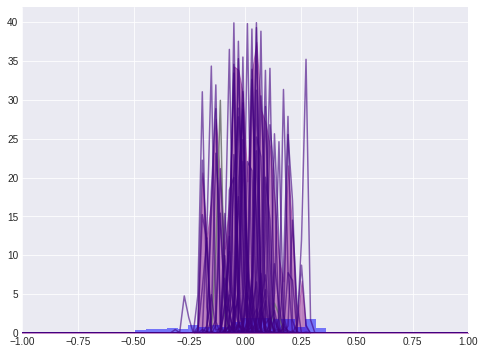

In [81]:
first_layer = tf.reshape(conv_layers[0].weights[0], shape=[-1])
x_plot = np.linspace(-1, 1, 100)
post_pdf_contribs = sp.stats.norm.pdf(
    np.atleast_3d(x_plot),
    prior_checks["mu"][:, np.newaxis, :],
    1/np.sqrt(10000)# / np.sqrt(prior_checks["lambda_"] * prior_checks["tau"])[:, np.newaxis, :]
)
post_pdfs = (prior_checks["w"][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-1, 1)

n_bins = 20
ax.hist(first_layer, bins=n_bins, density=True, color="blue", lw=0, alpha=0.5)

ax.fill_between(x_plot, post_pdf_low, post_pdf_high, color=[.5,0,.5], alpha=0.45)
ax.plot(x_plot, post_pdfs[0], c="gray", label="Posterior sample densities")
ax.plot(x_plot, post_pdfs[1:].T, c=[.25,0,.5], alpha=0.6)
fig.show()
#fig.savefig("further_from_alpha_high_stick_mixing_lambda_normal_moreskewed_tau.png")

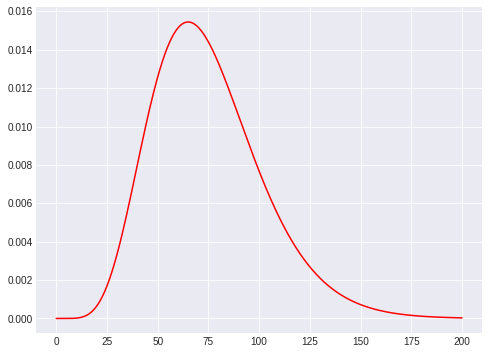

In [303]:
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(0, 200, 1000)
beta_1 = sp.stats.gamma.pdf(x_plot, .5, scale = 1/.5)
beta_2 = sp.stats.gamma.pdf(x_plot, 1, scale = 1/2)
beta_3 = sp.stats.gamma.pdf(x_plot, 7.5, scale = 10)
beta_4 = sp.stats.gamma.pdf(x_plot, .25, scale = 1/1)

#ax.plot(x_plot, beta_1, c="green")
#ax.plot(x_plot, beta_2, c="blue")
ax.plot(x_plot, beta_3, c="red")
#ax.plot(x_plot, beta_4, c="blue")
#ax.plot(x_plot, post_pdfs[1:].T, c=[.25,0,.5], alpha=0.6)
fig.show()

In [ ]:
prior_checks["w"][:, np.newaxis, :].mean(axis=0)

array([[5.61578853e-01, 2.21031947e-01, 8.96044869e-02, 5.51849388e-02,
        2.98979354e-02, 1.66307512e-02, 1.22692246e-02, 6.40726467e-03,
        2.67301009e-03, 1.75119866e-03, 1.14858001e-03, 2.74516979e-04,
        4.71238911e-04, 5.35363193e-04, 1.33826343e-04, 2.09892291e-04,
        8.47806069e-05, 6.95459828e-05, 1.69911910e-05, 7.72607944e-06,
        8.27283429e-06, 4.35396139e-06, 1.43726830e-06, 1.40541639e-06,
        6.59951609e-07, 5.19636849e-07, 6.06858281e-07, 1.77403918e-07,
        2.29383509e-07, 4.17205475e-08]])

#Inspecting CNN learned weights and fail-states

(103,)


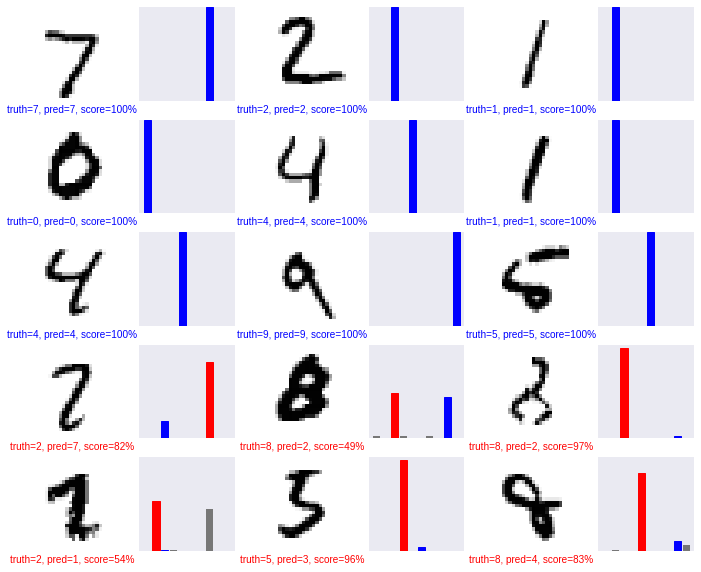

In [ ]:
class_names = [str(x) for x in range(10)]
predictions = model.predict(x_test)
ndx = find_interesting_test_images(predictions, y_test)
plot_interesting_test_results(x_test, y_test, predictions, class_names, ndx)

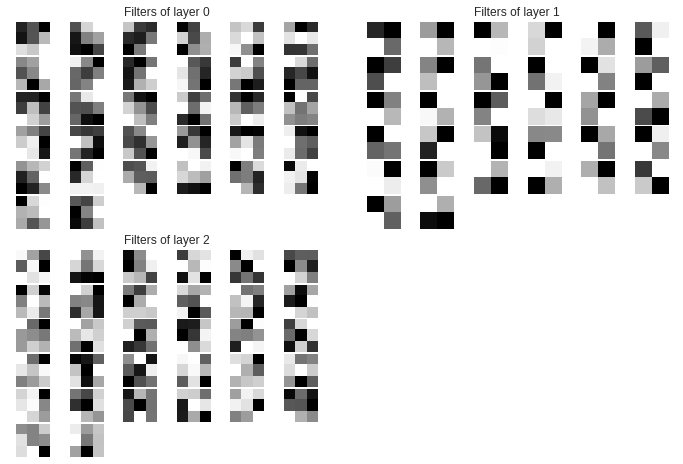

In [24]:
fig = plt.figure(figsize=(12, 8))

outer = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.1)
listi = list(range(0,6,2))
lookup = {32: 6, 64: 8}
var = [v for v in model.trainable_variables if "conv" in v.name]

for i, panel in enumerate(outer):
  if i >= 3:
    break
  tensor = tf.convert_to_tensor(var[listi[i]])
  value = lookup[tensor.shape[-1]]
  inner = gridspec.GridSpecFromSubplotSpec(value, value,
                  subplot_spec=panel, wspace=0.05, hspace=0.05)
  
  # set outer titles
  ax = plt.Subplot(fig, panel)
  ax.set_title(f"Filters of layer {i}")
  ax.axis("off")
  fig.add_subplot(ax)

  for j in range(tensor.shape[-1]):
      ax = plt.Subplot(fig, inner[j])
      ax.imshow(tensor[:,:,0,j])
      ax.set_xticks([])
      ax.set_yticks([])
      i += 1
      fig.add_subplot(ax)

Statistics